# Tumor Segmentation Notebook (Single-Device)

This notebook gives a practical workflow to tune training for the PET tumor segmentation task:

1. Build a **stratified** train/val split (control vs patient).
2. Use optional **balanced sampling** to reduce empty-mask dominance.
3. Train `SMP Unet` on one device with `model.to(device)` (no DDP).
4. Use repo `DiceLoss` directly, with optional Dice+BCE blend.
5. Inspect predictions, threshold sensitivity, and hard cases.


In [1]:
import os
import sys
import copy
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler

from tqdm.auto import tqdm


def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "train.py").exists() and (candidate / "criterions").exists():
            return candidate
    raise RuntimeError("Could not locate repository root from current working directory.")


REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f"REPO_ROOT = {REPO_ROOT}")

from datasets.TumorSegmentationDataset import (
    TumorSegmentationDataset,
    TumorSegmentationTrainTransform,
    TumorSegmentationEvalTransform,
)
from criterions.dice_loss import DiceLoss

import segmentation_models_pytorch as smp


REPO_ROOT = /home/yslcoat/projects/pytorch-training-toolbox


In [2]:
@dataclass
class CFG:
    # Data
    data_root: Path = REPO_ROOT / "tumor-segmentation" / "data"
    image_channels: int = 1
    image_height: int = 512
    image_width: int = 400

    # Split / sampling
    val_split: float = 0.2
    split_seed: int = 42
    target_control_fraction_in_sampler: float | None = None  # None = natural sampling.
    # Set to 0.5 for balanced control/patient, or >0.5 to bias toward controls.

    # Augmentation
    enable_augmentations: bool = True
    hflip_prob: float = 0.5
    vflip_prob: float = 0.5
    affine_prob: float = 0.3
    rotate_degrees: float = 30.0
    translate_ratio: float = 0.05
    scale_min: float = 0.95
    scale_max: float = 1.05
    color_jitter_prob: float = 0.0
    brightness: float = 0.15
    contrast: float = 0.15

    # Normalization (PET default; adjust if needed)
    normalize: bool = True
    normalization_mean: tuple[float, ...] = (0.485,)
    normalization_std: tuple[float, ...] = (0.229,)

    # Model
    encoder_name: str = "resnet34"
    encoder_weights: str | None = "imagenet"  # Use ImageNet init by default for this experiment.
    classes: int = 1
    activation: str | None = None

    # Optimization
    epochs: int = 300
    batch_size: int = 32
    num_workers: int = 0  # Keep 0 in notebooks to avoid worker teardown issues
    pin_memory: bool = True
    lr: float = 3e-4
    weight_decay: float = 1e-4

    # Loss formula
    loss_mode: str = "focal_tversky"  # "dice", "bce", "dice_bce", "tversky", "focal_tversky"
    bce_use_pos_weight: bool = True  # Set False for plain BCE without class weighting.
    dice_weight: float = 0.7
    bce_weight: float = 0.3
    tversky_alpha: float = 0.3  # Higher alpha penalizes FP more.
    tversky_beta: float = 0.7
    focal_tversky_gamma: float = 1.33

    # Metrics / inference
    threshold: float = 0.5  # Will be calibrated on validation after training.
    threshold_min_recall: float = 0.6
    threshold_fbeta_beta: float = 0.5
    dice_smooth: float = 1e-6

    # Misc
    seed: int = 42
    use_amp: bool = True


cfg = CFG()


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


seed_everything(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = bool(cfg.use_amp and device.type == "cuda")

print(f"device={device}, use_amp={use_amp}")
print(cfg)


device=cuda, use_amp=True
CFG(data_root=PosixPath('/home/yslcoat/projects/pytorch-training-toolbox/tumor-segmentation/data'), image_channels=1, image_height=512, image_width=400, val_split=0.2, split_seed=42, target_control_fraction_in_sampler=None, enable_augmentations=True, hflip_prob=0.5, vflip_prob=0.5, affine_prob=0.3, rotate_degrees=30.0, translate_ratio=0.05, scale_min=0.95, scale_max=1.05, color_jitter_prob=0.0, brightness=0.15, contrast=0.15, normalize=True, normalization_mean=(0.485,), normalization_std=(0.229,), encoder_name='resnet34', encoder_weights='imagenet', classes=1, activation=None, epochs=300, batch_size=32, num_workers=0, pin_memory=True, lr=0.0003, weight_decay=0.0001, loss_mode='focal_tversky', bce_use_pos_weight=True, dice_weight=0.7, bce_weight=0.3, tversky_alpha=0.3, tversky_beta=0.7, focal_tversky_gamma=1.33, threshold=0.5, threshold_min_recall=0.6, threshold_fbeta_beta=0.5, dice_smooth=1e-06, seed=42, use_amp=True)


In [3]:
# Build stratified split from a transform-free base dataset.
base_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=None,
)

sample_groups = [
    "control" if sample["is_control"] else "patient"
    for sample in base_dataset.samples
]


def stratified_split_indices(groups: list[str], val_split: float, seed: int) -> tuple[list[int], list[int]]:
    if not 0.0 < val_split < 1.0:
        raise ValueError(f"val_split must be in (0, 1), got {val_split}")

    rng = np.random.default_rng(seed)
    group_to_indices: dict[str, list[int]] = {}
    for idx, group in enumerate(groups):
        group_to_indices.setdefault(group, []).append(idx)

    train_idx: list[int] = []
    val_idx: list[int] = []

    for idxs in group_to_indices.values():
        idxs = idxs.copy()
        rng.shuffle(idxs)

        if len(idxs) == 1:
            train_idx.extend(idxs)
            continue

        n_val = int(round(len(idxs) * val_split))
        n_val = max(1, min(len(idxs) - 1, n_val))

        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx


class ComposeImageMaskTransforms:
    def __init__(self, *transforms):
        self.transforms = [t for t in transforms if t is not None]

    def __call__(self, image: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        for transform in self.transforms:
            image, mask = transform(image, mask)
        return image, mask


class ChannelAndNormalize:
    def __init__(self, image_channels: int, normalize: bool, mean: tuple[float, ...], std: tuple[float, ...]):
        self.image_channels = image_channels
        self.normalize = normalize
        self.mean = mean
        self.std = std

        if self.image_channels not in {1, 3}:
            raise ValueError(f"image_channels must be 1 or 3, got {self.image_channels}")

        if self.normalize:
            if len(self.mean) != self.image_channels or len(self.std) != self.image_channels:
                raise ValueError(
                    "Normalization stats length must match image_channels, got "
                    f"mean={len(self.mean)}, std={len(self.std)}, image_channels={self.image_channels}."
                )
            if any(v <= 0.0 for v in self.std):
                raise ValueError(f"All std values must be > 0, got {self.std}")

    def __call__(self, image: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Dataset currently returns RGB. PET scans are grayscale, so for 1-channel mode
        # we collapse RGB to a single channel.
        if self.image_channels == 1:
            if image.shape[0] == 1:
                image = image
            else:
                image = image.mean(dim=0, keepdim=True)
        else:
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)

        if self.normalize:
            mean_t = torch.tensor(self.mean, dtype=image.dtype).view(-1, 1, 1)
            std_t = torch.tensor(self.std, dtype=image.dtype).view(-1, 1, 1)
            image = (image - mean_t) / std_t

        return image, mask


train_indices, val_indices = stratified_split_indices(
    sample_groups,
    val_split=cfg.val_split,
    seed=cfg.split_seed,
)

train_base_transform = TumorSegmentationTrainTransform(
    image_height=cfg.image_height,
    image_width=cfg.image_width,
    hflip_prob=cfg.hflip_prob,
    vflip_prob=cfg.vflip_prob,
    affine_prob=cfg.affine_prob,
    rotate_degrees=cfg.rotate_degrees,
    translate_ratio=cfg.translate_ratio,
    scale_min=cfg.scale_min,
    scale_max=cfg.scale_max,
    color_jitter_prob=cfg.color_jitter_prob,
    brightness=cfg.brightness,
    contrast=cfg.contrast,
)

val_base_transform = TumorSegmentationEvalTransform(
    image_height=cfg.image_height,
    image_width=cfg.image_width,
)

post_transform = ChannelAndNormalize(
    image_channels=cfg.image_channels,
    normalize=cfg.normalize,
    mean=cfg.normalization_mean,
    std=cfg.normalization_std,
)

train_transform = ComposeImageMaskTransforms(train_base_transform, post_transform)
val_transform = ComposeImageMaskTransforms(val_base_transform, post_transform)

train_full_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=train_transform,
)
val_full_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=val_transform,
)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)


def summarize_subset(subset: Subset, subset_name: str) -> None:
    indices = list(subset.indices)
    base_samples = subset.dataset.samples

    num_controls = sum(1 for i in indices if base_samples[i]["is_control"])
    num_patients = len(indices) - num_controls

    empty_masks = 0
    pos_pixels = 0.0
    total_pixels = 0

    for _, mask in subset:
        s = float(mask.sum().item())
        if s == 0.0:
            empty_masks += 1
        pos_pixels += s
        total_pixels += mask.numel()

    print(f"[{subset_name}] samples={len(indices)}")
    print(f"[{subset_name}] controls={num_controls}, patients={num_patients}")
    print(f"[{subset_name}] empty_masks={empty_masks} ({empty_masks / len(indices):.3f})")
    print(f"[{subset_name}] positive_pixel_ratio={pos_pixels / max(total_pixels, 1):.6f}")


def build_class_ratio_sampler(subset: Subset, target_control_fraction: float) -> WeightedRandomSampler:
    if not 0.0 < target_control_fraction < 1.0:
        raise ValueError(
            f"target_control_fraction must be in (0, 1), got {target_control_fraction}."
        )

    indices = list(subset.indices)
    base_samples = subset.dataset.samples
    flags_is_control = [bool(base_samples[i]["is_control"]) for i in indices]

    n_controls = sum(flags_is_control)
    n_patients = len(flags_is_control) - n_controls
    if n_controls == 0 or n_patients == 0:
        raise ValueError("Class-ratio sampling requires both control and patient samples.")

    target_patient_fraction = 1.0 - target_control_fraction
    w_control = target_control_fraction / float(n_controls)
    w_patient = target_patient_fraction / float(n_patients)
    weights = [w_control if is_control else w_patient for is_control in flags_is_control]

    return WeightedRandomSampler(
        weights=torch.tensor(weights, dtype=torch.double),
        num_samples=len(weights),
        replacement=True,
    )


train_sampler = None
if cfg.target_control_fraction_in_sampler is not None:
    train_sampler = build_class_ratio_sampler(
        train_dataset,
        target_control_fraction=cfg.target_control_fraction_in_sampler,
    )

loader_kwargs = {
    "num_workers": cfg.num_workers,
    "pin_memory": bool(cfg.pin_memory and device.type == "cuda"),
}
if cfg.num_workers > 0:
    # Explicit spawn context is safer than fork in interactive notebooks.
    loader_kwargs["multiprocessing_context"] = "spawn"
    loader_kwargs["persistent_workers"] = True

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    **loader_kwargs,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    **loader_kwargs,
)

summarize_subset(train_dataset, "train")
summarize_subset(val_dataset, "val")
if cfg.target_control_fraction_in_sampler is None:
    print("train sampling: natural (dataset prior)")
else:
    print(f"train sampling target control fraction={cfg.target_control_fraction_in_sampler:.2f}")
print(f"train batches={len(train_loader)}, val batches={len(val_loader)}")


[train] samples=487
[train] controls=341, patients=146
[train] empty_masks=341 (0.700)
[train] positive_pixel_ratio=0.003781
[val] samples=121
[val] controls=85, patients=36
[val] empty_masks=85 (0.702)
[val] positive_pixel_ratio=0.003453
train sampling: natural (dataset prior)
train batches=16, val batches=4


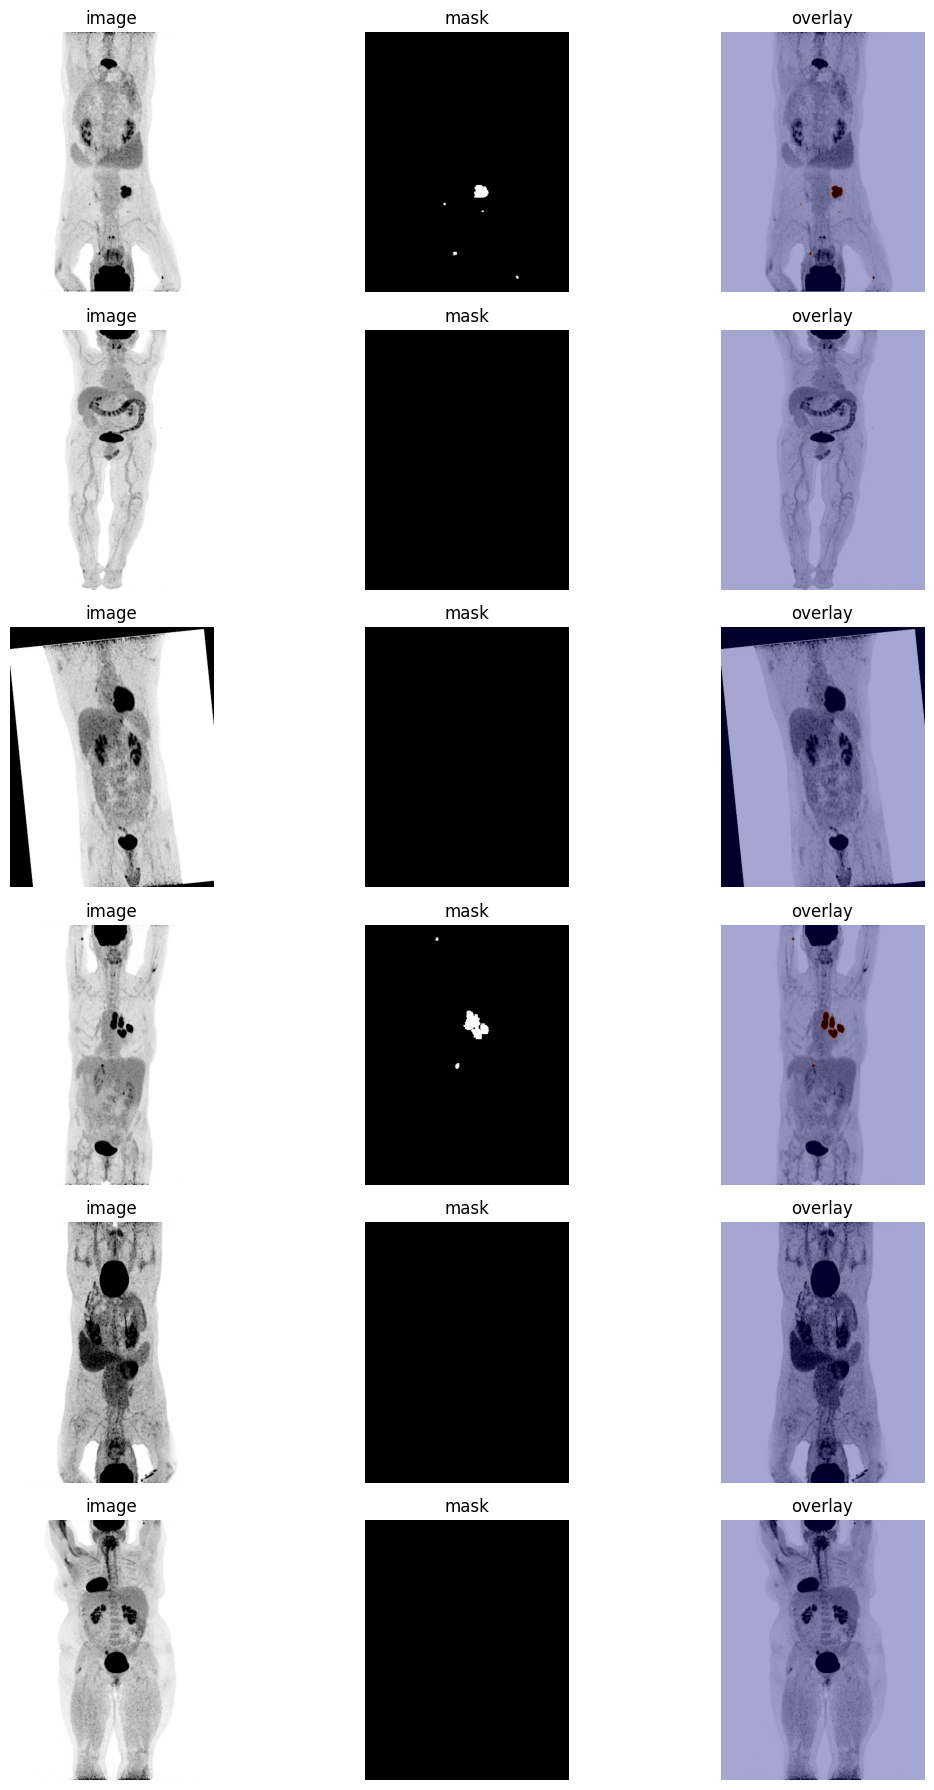

In [4]:
def denormalize_image_tensor(image: torch.Tensor) -> torch.Tensor:
    x = image.detach().cpu().clone()
    if not cfg.normalize:
        return x.clamp(0.0, 1.0)

    mean = torch.tensor(cfg.normalization_mean, dtype=x.dtype).view(-1, 1, 1)
    std = torch.tensor(cfg.normalization_std, dtype=x.dtype).view(-1, 1, 1)
    x = x * std + mean
    return x.clamp(0.0, 1.0)


def show_batch(images: torch.Tensor, masks: torch.Tensor, max_items: int = 6) -> None:
    k = min(max_items, images.shape[0])
    fig, axes = plt.subplots(k, 3, figsize=(12, 3 * k))
    if k == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(k):
        img = denormalize_image_tensor(images[i])
        mask = masks[i, 0].detach().cpu().numpy()

        if img.shape[0] == 1:
            img_np = img[0].numpy()
            axes[i, 0].imshow(img_np, cmap="gray")
            axes[i, 2].imshow(img_np, cmap="gray")
        else:
            img_np = img.permute(1, 2, 0).numpy()
            axes[i, 0].imshow(img_np)
            axes[i, 2].imshow(img_np)

        axes[i, 1].imshow(mask, cmap="gray", vmin=0, vmax=1)
        axes[i, 2].imshow(mask, cmap="jet", alpha=0.35, vmin=0, vmax=1)

        axes[i, 0].set_title("image")
        axes[i, 1].set_title("mask")
        axes[i, 2].set_title("overlay")

        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


batch_images, batch_masks = next(iter(train_loader))
show_batch(batch_images, batch_masks)


In [5]:
model = smp.Unet(
    encoder_name=cfg.encoder_name,
    encoder_weights=cfg.encoder_weights,
    in_channels=cfg.image_channels,
    classes=cfg.classes,
    activation=cfg.activation,
).to(device)

repo_dice_loss = DiceLoss(
    smooth=cfg.dice_smooth,
    from_logits=True,
    reduction="mean",
)


def estimate_pos_weight(loader: DataLoader, max_batches: int = 32) -> torch.Tensor:
    pos = 0.0
    total = 0.0
    for batch_idx, (_, masks) in enumerate(loader):
        if batch_idx >= max_batches:
            break
        pos += float(masks.sum().item())
        total += float(masks.numel())

    neg = max(total - pos, 1.0)
    pos = max(pos, 1.0)
    return torch.tensor([neg / pos], dtype=torch.float32)


class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight: float, bce_weight: float, pos_weight: torch.Tensor | None = None):
        super().__init__()
        self.dice_weight = float(dice_weight)
        self.bce_weight = float(bce_weight)
        self.dice = repo_dice_loss
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.dice_weight * self.dice(logits, targets) + self.bce_weight * self.bce(logits, targets)


class TverskyLoss(nn.Module):
    def __init__(
        self,
        alpha: float = 0.7,
        beta: float = 0.3,
        smooth: float = 1e-6,
        focal_gamma: float | None = None,
    ):
        super().__init__()
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.smooth = float(smooth)
        self.focal_gamma = None if focal_gamma is None else float(focal_gamma)

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if logits.dim() == targets.dim() + 1 and logits.shape[1] == 1:
            targets = targets.unsqueeze(1)
        if logits.shape != targets.shape:
            raise ValueError(
                "Tversky loss expects logits/targets with same shape, got "
                f"{tuple(logits.shape)} and {tuple(targets.shape)}."
            )

        probs = torch.sigmoid(logits)
        targets = targets.to(dtype=probs.dtype)

        probs_flat = probs.reshape(probs.shape[0], -1)
        targets_flat = targets.reshape(targets.shape[0], -1)

        tp = (probs_flat * targets_flat).sum(dim=1)
        fp = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        fn = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        loss = 1.0 - tversky
        if self.focal_gamma is not None:
            loss = loss.pow(self.focal_gamma)
        return loss.mean()


if cfg.loss_mode == "dice":
    criterion = repo_dice_loss
elif cfg.loss_mode == "bce":
    pos_weight = estimate_pos_weight(train_loader).to(device) if cfg.bce_use_pos_weight else None
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    if pos_weight is None:
        print("Using BCEWithLogitsLoss (no pos_weight)")
    else:
        print(f"Using BCEWithLogitsLoss with pos_weight={pos_weight.item():.4f}")
elif cfg.loss_mode == "dice_bce":
    pos_weight = estimate_pos_weight(train_loader).to(device)
    criterion = DiceBCELoss(cfg.dice_weight, cfg.bce_weight, pos_weight=pos_weight)
    print(f"Using Dice+BCE with pos_weight={pos_weight.item():.4f}")
elif cfg.loss_mode == "tversky":
    criterion = TverskyLoss(
        alpha=cfg.tversky_alpha,
        beta=cfg.tversky_beta,
        smooth=cfg.dice_smooth,
        focal_gamma=None,
    )
    print(
        f"Using Tversky loss (alpha={cfg.tversky_alpha:.2f}, beta={cfg.tversky_beta:.2f})"
    )
elif cfg.loss_mode == "focal_tversky":
    criterion = TverskyLoss(
        alpha=cfg.tversky_alpha,
        beta=cfg.tversky_beta,
        smooth=cfg.dice_smooth,
        focal_gamma=cfg.focal_tversky_gamma,
    )
    print(
        "Using Focal-Tversky loss "
        f"(alpha={cfg.tversky_alpha:.2f}, beta={cfg.tversky_beta:.2f}, gamma={cfg.focal_tversky_gamma:.2f})"
    )
else:
    raise ValueError(
        f"Unsupported loss_mode: {cfg.loss_mode}. "
        "Choose from ['dice', 'bce', 'dice_bce', 'tversky', 'focal_tversky']."
    )

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

def build_grad_scaler(enabled: bool):
    try:
        return torch.amp.GradScaler("cuda", enabled=enabled)
    except (AttributeError, TypeError):
        return torch.cuda.amp.GradScaler(enabled=enabled)


scaler = build_grad_scaler(enabled=use_amp)
print(model.__class__.__name__, "ready")


Using Focal-Tversky loss (alpha=0.30, beta=0.70, gamma=1.33)
Unet ready


In [6]:
def autocast_context():
    if use_amp:
        return torch.autocast(device_type="cuda", dtype=torch.float16)
    from contextlib import nullcontext
    return nullcontext()


def _prepare_dice_tensors(outputs: torch.Tensor, targets: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    if outputs.dim() == targets.dim() + 1 and outputs.shape[1] == 1:
        targets = targets.unsqueeze(1)

    if outputs.shape != targets.shape:
        raise ValueError(
            "Dice metric expects outputs/targets with same shape, got "
            f"{tuple(outputs.shape)} and {tuple(targets.shape)}."
        )

    return outputs, targets.to(dtype=outputs.dtype)


def dice_metric(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    from_logits: bool = True,
    threshold: float = 0.5,
    smooth: float = 1e-6,
) -> torch.Tensor:
    outputs, targets = _prepare_dice_tensors(outputs, targets)

    if from_logits:
        outputs = torch.sigmoid(outputs)

    preds = (outputs >= threshold).to(dtype=outputs.dtype)

    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)

    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1)
    dice = (2.0 * inter + smooth) / (union + smooth)
    return dice.mean()


def per_sample_dice_from_logits(logits: torch.Tensor, targets: torch.Tensor, threshold: float, eps: float = 1e-6) -> torch.Tensor:
    logits, targets = _prepare_dice_tensors(logits, targets)

    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).to(dtype=targets.dtype)

    preds_flat = preds.reshape(preds.shape[0], -1)
    targets_flat = targets.reshape(targets.shape[0], -1)

    inter = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)
    return (2.0 * inter + eps) / (union + eps)


def per_sample_accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor, threshold: float) -> torch.Tensor:
    logits, targets = _prepare_dice_tensors(logits, targets)

    probs = torch.sigmoid(logits)
    preds = probs >= threshold
    targets_bin = targets >= 0.5

    correct = (preds == targets_bin).to(dtype=logits.dtype)
    return correct.reshape(correct.shape[0], -1).mean(dim=1)


def run_epoch(model: nn.Module, loader: DataLoader, train: bool) -> dict[str, float]:
    model.train(mode=train)

    total_loss = 0.0
    total_dice = 0.0
    total_accuracy = 0.0
    total_samples = 0

    pos_only_dice_sum = 0.0
    pos_only_count = 0

    pbar = tqdm(loader, leave=True, desc=("train" if train else "val"))
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            with autocast_context():
                logits = model(images)
                loss = criterion(logits, targets)

            if train:
                optimizer.zero_grad(set_to_none=True)
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        with torch.no_grad():
            batch_size = images.shape[0]
            batch_dice = per_sample_dice_from_logits(logits, targets, threshold=cfg.threshold)
            batch_acc = per_sample_accuracy_from_logits(logits, targets, threshold=cfg.threshold)

            total_loss += float(loss.item()) * batch_size
            total_dice += float(batch_dice.mean().item()) * batch_size
            total_accuracy += float(batch_acc.mean().item()) * batch_size
            total_samples += batch_size

            has_positive = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
            if has_positive.any():
                pos_only_dice_sum += float(batch_dice[has_positive].sum().item())
                pos_only_count += int(has_positive.sum().item())

            avg_loss = total_loss / max(total_samples, 1)
            avg_dice = total_dice / max(total_samples, 1)
            avg_acc = total_accuracy / max(total_samples, 1)
            pbar.set_postfix(loss=f"{avg_loss:.4f}", dice=f"{avg_dice:.4f}", acc=f"{avg_acc:.4f}")

    return {
        "loss": total_loss / max(total_samples, 1),
        "dice": total_dice / max(total_samples, 1),
        "accuracy": total_accuracy / max(total_samples, 1),
        "dice_pos_only": pos_only_dice_sum / max(pos_only_count, 1),
    }


def evaluate_metric_module(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            logits = model(images)
            total += float(
                dice_metric(
                    logits,
                    targets,
                    from_logits=True,
                    threshold=cfg.threshold,
                    smooth=cfg.dice_smooth,
                ).item()
            ) * images.shape[0]
            n += images.shape[0]
    return total / max(n, 1)


In [7]:
history = {
    "train_loss": [],
    "train_dice": [],
    "train_accuracy": [],
    "train_dice_pos_only": [],
    "val_loss": [],
    "val_dice": [],
    "val_accuracy": [],
    "val_dice_pos_only": [],
    "val_dice_metric_module": [],
    "lr": [],
}

best_state = None
best_score = -1.0

for epoch in range(1, cfg.epochs + 1):
    print(f"Starting epoch {epoch}/{cfg.epochs}...")
    train_stats = run_epoch(model, train_loader, train=True)
    val_stats = run_epoch(model, val_loader, train=False)
    val_dice_metric_module = evaluate_metric_module(model, val_loader)


    history["train_loss"].append(train_stats["loss"])
    history["train_dice"].append(train_stats["dice"])
    history["train_accuracy"].append(train_stats["accuracy"])
    history["train_dice_pos_only"].append(train_stats["dice_pos_only"])
    history["val_loss"].append(val_stats["loss"])
    history["val_dice"].append(val_stats["dice"])
    history["val_accuracy"].append(val_stats["accuracy"])
    history["val_dice_pos_only"].append(val_stats["dice_pos_only"])
    history["val_dice_metric_module"].append(val_dice_metric_module)
    history["lr"].append(float(optimizer.param_groups[0]["lr"]))

    score_for_selection = val_stats["dice_pos_only"]
    if score_for_selection > best_score:
        best_score = score_for_selection
        best_state = copy.deepcopy(model.state_dict())

    print(
        f"Epoch {epoch:03d}/{cfg.epochs} | "
        f"train_loss={train_stats['loss']:.4f} train_dice={train_stats['dice']:.4f} train_acc={train_stats['accuracy']:.4f} | "
        f"val_loss={val_stats['loss']:.4f} val_dice={val_stats['dice']:.4f} val_acc={val_stats['accuracy']:.4f} "
        f"val_dice_pos_only={val_stats['dice_pos_only']:.4f} "
        f"val_dice_metric_module={val_dice_metric_module:.4f}"
    )

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model by val_dice_pos_only={best_score:.4f}")


Starting epoch 1/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001/300 | train_loss=0.9656 train_dice=nan train_acc=0.6019 | val_loss=0.9736 val_dice=0.0048 val_acc=0.1500 val_dice_pos_only=0.0161 val_dice_metric_module=0.0134
Starting epoch 2/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 002/300 | train_loss=0.9341 train_dice=0.0579 train_acc=0.4870 | val_loss=0.9278 val_dice=0.0491 val_acc=0.4823 val_dice_pos_only=0.1649 val_dice_metric_module=0.0520
Starting epoch 3/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 003/300 | train_loss=0.9040 train_dice=nan train_acc=0.4888 | val_loss=0.8763 val_dice=0.1167 val_acc=0.5819 val_dice_pos_only=0.3921 val_dice_metric_module=0.1175
Starting epoch 4/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 004/300 | train_loss=0.8822 train_dice=0.1084 train_acc=0.4411 | val_loss=0.8516 val_dice=0.1239 val_acc=0.9242 val_dice_pos_only=0.4164 val_dice_metric_module=0.1241
Starting epoch 5/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 005/300 | train_loss=0.8712 train_dice=0.1056 train_acc=0.4483 | val_loss=0.9393 val_dice=0.0443 val_acc=0.1647 val_dice_pos_only=0.1490 val_dice_metric_module=0.0490
Starting epoch 6/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 006/300 | train_loss=0.8668 train_dice=nan train_acc=0.5243 | val_loss=0.8435 val_dice=0.1253 val_acc=0.7936 val_dice_pos_only=0.4211 val_dice_metric_module=0.1256
Starting epoch 7/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 007/300 | train_loss=0.8853 train_dice=0.0924 train_acc=0.6302 | val_loss=0.8655 val_dice=0.1101 val_acc=0.7106 val_dice_pos_only=0.3701 val_dice_metric_module=0.1105
Starting epoch 8/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 008/300 | train_loss=0.8522 train_dice=0.1245 train_acc=0.6840 | val_loss=0.8703 val_dice=0.1204 val_acc=0.5777 val_dice_pos_only=0.4045 val_dice_metric_module=0.1211
Starting epoch 9/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 009/300 | train_loss=0.8367 train_dice=0.1430 train_acc=0.6935 | val_loss=0.9172 val_dice=0.0843 val_acc=0.5032 val_dice_pos_only=0.2833 val_dice_metric_module=0.0857
Starting epoch 10/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 010/300 | train_loss=0.8246 train_dice=0.1598 train_acc=0.7229 | val_loss=0.8423 val_dice=0.1287 val_acc=0.8298 val_dice_pos_only=0.4326 val_dice_metric_module=0.1296
Starting epoch 11/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 011/300 | train_loss=0.8319 train_dice=0.1472 train_acc=0.6864 | val_loss=0.8076 val_dice=0.1649 val_acc=0.8138 val_dice_pos_only=0.5543 val_dice_metric_module=0.1650
Starting epoch 12/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 012/300 | train_loss=0.8270 train_dice=nan train_acc=0.7432 | val_loss=0.8658 val_dice=0.1159 val_acc=0.5274 val_dice_pos_only=0.3897 val_dice_metric_module=0.1165
Starting epoch 13/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 013/300 | train_loss=0.8250 train_dice=0.1559 train_acc=0.7565 | val_loss=0.8513 val_dice=0.1294 val_acc=0.5577 val_dice_pos_only=0.4349 val_dice_metric_module=0.1313
Starting epoch 14/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 014/300 | train_loss=0.8198 train_dice=nan train_acc=0.8088 | val_loss=0.8157 val_dice=0.1556 val_acc=0.8779 val_dice_pos_only=0.5230 val_dice_metric_module=0.1556
Starting epoch 15/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 015/300 | train_loss=0.8185 train_dice=nan train_acc=0.8295 | val_loss=0.8314 val_dice=0.1573 val_acc=0.7168 val_dice_pos_only=0.5286 val_dice_metric_module=0.1579
Starting epoch 16/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 016/300 | train_loss=0.7957 train_dice=0.1826 train_acc=0.8339 | val_loss=0.8001 val_dice=0.1717 val_acc=0.6465 val_dice_pos_only=0.5772 val_dice_metric_module=0.1723
Starting epoch 17/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 017/300 | train_loss=0.8008 train_dice=0.1762 train_acc=0.7767 | val_loss=0.8063 val_dice=0.1494 val_acc=0.9834 val_dice_pos_only=0.5022 val_dice_metric_module=0.1494
Starting epoch 18/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 018/300 | train_loss=0.7926 train_dice=0.1810 train_acc=0.8111 | val_loss=0.8364 val_dice=0.1542 val_acc=0.9426 val_dice_pos_only=0.5182 val_dice_metric_module=0.1544
Starting epoch 19/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 019/300 | train_loss=0.8064 train_dice=0.1740 train_acc=0.8140 | val_loss=0.7936 val_dice=0.1839 val_acc=0.6184 val_dice_pos_only=0.6180 val_dice_metric_module=0.1841
Starting epoch 20/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 020/300 | train_loss=0.7836 train_dice=0.1914 train_acc=0.8335 | val_loss=0.7837 val_dice=0.1978 val_acc=0.8947 val_dice_pos_only=0.6649 val_dice_metric_module=0.1978
Starting epoch 21/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 021/300 | train_loss=0.8021 train_dice=0.1712 train_acc=0.8386 | val_loss=0.7894 val_dice=0.1726 val_acc=0.8764 val_dice_pos_only=0.5803 val_dice_metric_module=0.1726
Starting epoch 22/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 022/300 | train_loss=0.7986 train_dice=0.1749 train_acc=0.8105 | val_loss=0.7925 val_dice=0.1849 val_acc=0.5603 val_dice_pos_only=0.6216 val_dice_metric_module=0.1848
Starting epoch 23/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 023/300 | train_loss=0.7986 train_dice=nan train_acc=0.8470 | val_loss=0.8506 val_dice=0.1449 val_acc=0.6956 val_dice_pos_only=0.4870 val_dice_metric_module=0.1453
Starting epoch 24/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 024/300 | train_loss=0.7941 train_dice=0.1961 train_acc=0.8700 | val_loss=0.8740 val_dice=0.1166 val_acc=0.4220 val_dice_pos_only=0.3919 val_dice_metric_module=0.1178
Starting epoch 25/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 025/300 | train_loss=0.7871 train_dice=nan train_acc=0.8940 | val_loss=0.7963 val_dice=0.1594 val_acc=0.9866 val_dice_pos_only=0.5356 val_dice_metric_module=0.1594
Starting epoch 26/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 026/300 | train_loss=0.7808 train_dice=0.1966 train_acc=0.8832 | val_loss=0.7797 val_dice=0.1999 val_acc=0.9925 val_dice_pos_only=0.6444 val_dice_metric_module=0.2000
Starting epoch 27/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 027/300 | train_loss=0.7820 train_dice=nan train_acc=0.8684 | val_loss=0.7923 val_dice=0.1958 val_acc=0.9570 val_dice_pos_only=0.6304 val_dice_metric_module=0.1958
Starting epoch 28/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 028/300 | train_loss=0.7767 train_dice=0.1988 train_acc=0.8954 | val_loss=0.7909 val_dice=0.1842 val_acc=0.9123 val_dice_pos_only=0.6192 val_dice_metric_module=0.1842
Starting epoch 29/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 029/300 | train_loss=0.7763 train_dice=0.1963 train_acc=0.8912 | val_loss=0.7845 val_dice=0.1942 val_acc=0.7709 val_dice_pos_only=0.6528 val_dice_metric_module=0.1942
Starting epoch 30/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 030/300 | train_loss=0.7722 train_dice=0.1956 train_acc=0.8875 | val_loss=0.7724 val_dice=0.2018 val_acc=0.8403 val_dice_pos_only=0.6783 val_dice_metric_module=0.2018
Starting epoch 31/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 031/300 | train_loss=0.7704 train_dice=0.1974 train_acc=0.8778 | val_loss=0.7664 val_dice=0.1989 val_acc=0.9245 val_dice_pos_only=0.6686 val_dice_metric_module=0.1989
Starting epoch 32/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 032/300 | train_loss=0.7661 train_dice=0.2055 train_acc=0.8998 | val_loss=0.7758 val_dice=0.1930 val_acc=0.9415 val_dice_pos_only=0.6489 val_dice_metric_module=0.1930
Starting epoch 33/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 033/300 | train_loss=0.7662 train_dice=0.2066 train_acc=0.8500 | val_loss=0.7758 val_dice=0.1904 val_acc=0.7975 val_dice_pos_only=0.6398 val_dice_metric_module=0.1906
Starting epoch 34/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 034/300 | train_loss=0.7614 train_dice=0.2081 train_acc=0.8749 | val_loss=0.7697 val_dice=0.2034 val_acc=0.7485 val_dice_pos_only=0.6838 val_dice_metric_module=0.2034
Starting epoch 35/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 035/300 | train_loss=0.7602 train_dice=0.2103 train_acc=0.8709 | val_loss=0.7833 val_dice=0.1934 val_acc=0.8280 val_dice_pos_only=0.6498 val_dice_metric_module=0.1933
Starting epoch 36/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 036/300 | train_loss=0.7640 train_dice=0.2117 train_acc=0.8588 | val_loss=0.7713 val_dice=0.2039 val_acc=0.6791 val_dice_pos_only=0.6852 val_dice_metric_module=0.2038
Starting epoch 37/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 037/300 | train_loss=0.7761 train_dice=0.2023 train_acc=0.8712 | val_loss=0.8224 val_dice=0.1698 val_acc=0.6965 val_dice_pos_only=0.5706 val_dice_metric_module=0.1701
Starting epoch 38/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 038/300 | train_loss=0.7665 train_dice=0.2120 train_acc=0.8949 | val_loss=0.8346 val_dice=0.1490 val_acc=0.6847 val_dice_pos_only=0.5008 val_dice_metric_module=0.1506
Starting epoch 39/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 039/300 | train_loss=0.7778 train_dice=0.1933 train_acc=0.9194 | val_loss=0.7798 val_dice=0.1756 val_acc=0.8481 val_dice_pos_only=0.5902 val_dice_metric_module=0.1756
Starting epoch 40/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 040/300 | train_loss=0.7704 train_dice=nan train_acc=0.9120 | val_loss=0.7732 val_dice=0.2219 val_acc=0.9680 val_dice_pos_only=0.6348 val_dice_metric_module=0.2219
Starting epoch 41/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 041/300 | train_loss=0.7751 train_dice=0.1982 train_acc=0.8896 | val_loss=0.7731 val_dice=0.1993 val_acc=0.9617 val_dice_pos_only=0.6697 val_dice_metric_module=0.1993
Starting epoch 42/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 042/300 | train_loss=0.7616 train_dice=0.2152 train_acc=0.8867 | val_loss=0.7747 val_dice=0.1955 val_acc=0.9181 val_dice_pos_only=0.6570 val_dice_metric_module=0.1955
Starting epoch 43/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 043/300 | train_loss=0.7623 train_dice=0.2139 train_acc=0.9268 | val_loss=0.7838 val_dice=0.1953 val_acc=0.8896 val_dice_pos_only=0.6564 val_dice_metric_module=0.1953
Starting epoch 44/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 044/300 | train_loss=0.7546 train_dice=0.2129 train_acc=0.9075 | val_loss=0.7640 val_dice=0.2047 val_acc=0.9684 val_dice_pos_only=0.6882 val_dice_metric_module=0.2047
Starting epoch 45/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 045/300 | train_loss=0.7530 train_dice=0.2178 train_acc=0.8999 | val_loss=0.7671 val_dice=0.1960 val_acc=0.9764 val_dice_pos_only=0.6586 val_dice_metric_module=0.1960
Starting epoch 46/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 046/300 | train_loss=0.7579 train_dice=0.2082 train_acc=0.9061 | val_loss=0.7787 val_dice=0.1963 val_acc=0.9093 val_dice_pos_only=0.6598 val_dice_metric_module=0.1964
Starting epoch 47/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 047/300 | train_loss=0.7557 train_dice=0.2156 train_acc=0.9225 | val_loss=0.7722 val_dice=0.2025 val_acc=0.8470 val_dice_pos_only=0.6806 val_dice_metric_module=0.2025
Starting epoch 48/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 048/300 | train_loss=0.7593 train_dice=nan train_acc=0.8835 | val_loss=0.7736 val_dice=0.1978 val_acc=0.7154 val_dice_pos_only=0.6649 val_dice_metric_module=0.1978
Starting epoch 49/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 049/300 | train_loss=0.7477 train_dice=0.2241 train_acc=0.8809 | val_loss=0.7813 val_dice=0.1922 val_acc=0.6667 val_dice_pos_only=0.6462 val_dice_metric_module=0.1922
Starting epoch 50/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 050/300 | train_loss=0.7542 train_dice=0.2163 train_acc=0.8933 | val_loss=0.7690 val_dice=0.1992 val_acc=0.9498 val_dice_pos_only=0.6694 val_dice_metric_module=0.1991
Starting epoch 51/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 051/300 | train_loss=0.7565 train_dice=0.2154 train_acc=0.8901 | val_loss=0.7754 val_dice=0.1872 val_acc=0.9520 val_dice_pos_only=0.6293 val_dice_metric_module=0.1873
Starting epoch 52/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 052/300 | train_loss=0.7577 train_dice=0.2178 train_acc=0.8979 | val_loss=0.7982 val_dice=0.2024 val_acc=0.8241 val_dice_pos_only=0.5968 val_dice_metric_module=0.2023
Starting epoch 53/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 053/300 | train_loss=0.7531 train_dice=0.2322 train_acc=0.9002 | val_loss=0.7737 val_dice=0.1918 val_acc=0.8390 val_dice_pos_only=0.6447 val_dice_metric_module=0.1918
Starting epoch 54/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 054/300 | train_loss=0.7522 train_dice=0.2188 train_acc=0.9154 | val_loss=0.8117 val_dice=0.1732 val_acc=0.6459 val_dice_pos_only=0.5821 val_dice_metric_module=0.1733
Starting epoch 55/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 055/300 | train_loss=0.7500 train_dice=0.2218 train_acc=0.9204 | val_loss=0.7697 val_dice=0.1935 val_acc=0.9597 val_dice_pos_only=0.6504 val_dice_metric_module=0.1935
Starting epoch 56/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 056/300 | train_loss=0.7555 train_dice=nan train_acc=0.9461 | val_loss=0.7703 val_dice=0.1950 val_acc=0.9665 val_dice_pos_only=0.6555 val_dice_metric_module=0.1951
Starting epoch 57/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 057/300 | train_loss=0.7497 train_dice=0.2169 train_acc=0.9522 | val_loss=0.8035 val_dice=0.1783 val_acc=0.8294 val_dice_pos_only=0.5992 val_dice_metric_module=0.1783
Starting epoch 58/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 058/300 | train_loss=0.7633 train_dice=nan train_acc=0.9629 | val_loss=0.7842 val_dice=0.1739 val_acc=0.9842 val_dice_pos_only=0.5843 val_dice_metric_module=0.1739
Starting epoch 59/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 059/300 | train_loss=0.7573 train_dice=0.2107 train_acc=0.9636 | val_loss=0.8134 val_dice=0.1707 val_acc=0.9060 val_dice_pos_only=0.5737 val_dice_metric_module=0.1707
Starting epoch 60/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 060/300 | train_loss=0.7549 train_dice=0.2188 train_acc=0.9501 | val_loss=0.7773 val_dice=0.1977 val_acc=0.8348 val_dice_pos_only=0.6644 val_dice_metric_module=0.1976
Starting epoch 61/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 061/300 | train_loss=0.7560 train_dice=0.2185 train_acc=0.9214 | val_loss=0.7822 val_dice=0.1976 val_acc=0.9331 val_dice_pos_only=0.6363 val_dice_metric_module=0.1976
Starting epoch 62/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 062/300 | train_loss=0.7575 train_dice=nan train_acc=0.9329 | val_loss=0.7772 val_dice=0.1963 val_acc=0.8694 val_dice_pos_only=0.6598 val_dice_metric_module=0.1963
Starting epoch 63/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 063/300 | train_loss=0.7522 train_dice=0.2167 train_acc=0.9415 | val_loss=0.7620 val_dice=0.2117 val_acc=0.9795 val_dice_pos_only=0.6837 val_dice_metric_module=0.2117
Starting epoch 64/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 064/300 | train_loss=0.7472 train_dice=0.2351 train_acc=0.9395 | val_loss=0.7761 val_dice=0.2000 val_acc=0.9527 val_dice_pos_only=0.6723 val_dice_metric_module=0.2000
Starting epoch 65/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 065/300 | train_loss=0.7492 train_dice=0.2212 train_acc=0.9525 | val_loss=0.7825 val_dice=0.2025 val_acc=0.9424 val_dice_pos_only=0.6808 val_dice_metric_module=0.2026
Starting epoch 66/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 066/300 | train_loss=0.7528 train_dice=0.2217 train_acc=0.9612 | val_loss=0.7720 val_dice=0.2025 val_acc=0.9683 val_dice_pos_only=0.6807 val_dice_metric_module=0.2025
Starting epoch 67/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 067/300 | train_loss=0.7531 train_dice=0.2265 train_acc=0.9385 | val_loss=0.8014 val_dice=0.1967 val_acc=0.7253 val_dice_pos_only=0.6056 val_dice_metric_module=0.1969
Starting epoch 68/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 068/300 | train_loss=0.7527 train_dice=0.2240 train_acc=0.9347 | val_loss=0.7734 val_dice=0.1922 val_acc=0.9537 val_dice_pos_only=0.6461 val_dice_metric_module=0.1922
Starting epoch 69/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 069/300 | train_loss=0.7497 train_dice=0.2220 train_acc=0.9407 | val_loss=0.7870 val_dice=0.1846 val_acc=0.7801 val_dice_pos_only=0.6204 val_dice_metric_module=0.1846
Starting epoch 70/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 070/300 | train_loss=0.7578 train_dice=nan train_acc=0.9506 | val_loss=0.7743 val_dice=0.2094 val_acc=0.9358 val_dice_pos_only=0.6484 val_dice_metric_module=0.2095
Starting epoch 71/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 071/300 | train_loss=0.7695 train_dice=0.1980 train_acc=0.9506 | val_loss=0.8364 val_dice=0.1492 val_acc=0.9651 val_dice_pos_only=0.5014 val_dice_metric_module=0.1492
Starting epoch 72/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 072/300 | train_loss=0.7567 train_dice=0.2123 train_acc=0.9490 | val_loss=0.7822 val_dice=0.1762 val_acc=0.9452 val_dice_pos_only=0.5921 val_dice_metric_module=0.1762
Starting epoch 73/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 073/300 | train_loss=0.7533 train_dice=0.2151 train_acc=0.9460 | val_loss=0.7784 val_dice=0.1850 val_acc=0.9840 val_dice_pos_only=0.6217 val_dice_metric_module=0.1850
Starting epoch 74/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 074/300 | train_loss=0.7516 train_dice=0.2207 train_acc=0.9466 | val_loss=0.7776 val_dice=0.1986 val_acc=0.9160 val_dice_pos_only=0.6677 val_dice_metric_module=0.1987
Starting epoch 75/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 075/300 | train_loss=0.7469 train_dice=0.2219 train_acc=0.9506 | val_loss=0.7660 val_dice=0.2031 val_acc=0.9482 val_dice_pos_only=0.6825 val_dice_metric_module=0.2031
Starting epoch 76/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 076/300 | train_loss=0.7422 train_dice=0.2258 train_acc=0.9489 | val_loss=0.7751 val_dice=0.2057 val_acc=0.8987 val_dice_pos_only=0.6916 val_dice_metric_module=0.2057
Starting epoch 77/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 077/300 | train_loss=0.7449 train_dice=0.2254 train_acc=0.9532 | val_loss=0.7711 val_dice=0.2032 val_acc=0.8222 val_dice_pos_only=0.6832 val_dice_metric_module=0.2033
Starting epoch 78/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 078/300 | train_loss=0.7456 train_dice=0.2246 train_acc=0.9520 | val_loss=0.7812 val_dice=0.1998 val_acc=0.9136 val_dice_pos_only=0.6717 val_dice_metric_module=0.1998
Starting epoch 79/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 079/300 | train_loss=0.7430 train_dice=nan train_acc=0.9427 | val_loss=0.7808 val_dice=0.1799 val_acc=0.9520 val_dice_pos_only=0.6047 val_dice_metric_module=0.1799
Starting epoch 80/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 080/300 | train_loss=0.7597 train_dice=0.2244 train_acc=0.9384 | val_loss=0.7730 val_dice=0.1909 val_acc=0.9896 val_dice_pos_only=0.6416 val_dice_metric_module=0.1909
Starting epoch 81/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 081/300 | train_loss=0.7558 train_dice=0.2092 train_acc=0.9445 | val_loss=0.7822 val_dice=0.2172 val_acc=0.9166 val_dice_pos_only=0.6468 val_dice_metric_module=0.2172
Starting epoch 82/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 082/300 | train_loss=0.7455 train_dice=0.2275 train_acc=0.9370 | val_loss=0.7634 val_dice=0.2040 val_acc=0.9744 val_dice_pos_only=0.6858 val_dice_metric_module=0.2041
Starting epoch 83/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 083/300 | train_loss=0.7448 train_dice=0.2260 train_acc=0.9436 | val_loss=0.7678 val_dice=0.2048 val_acc=0.9129 val_dice_pos_only=0.6885 val_dice_metric_module=0.2049
Starting epoch 84/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 084/300 | train_loss=0.7417 train_dice=0.2346 train_acc=0.9528 | val_loss=0.7769 val_dice=0.2004 val_acc=0.9685 val_dice_pos_only=0.6734 val_dice_metric_module=0.2003
Starting epoch 85/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 085/300 | train_loss=0.7408 train_dice=0.2354 train_acc=0.9589 | val_loss=0.7779 val_dice=0.1986 val_acc=0.9151 val_dice_pos_only=0.6675 val_dice_metric_module=0.1986
Starting epoch 86/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 086/300 | train_loss=0.7416 train_dice=0.2320 train_acc=0.9521 | val_loss=0.7687 val_dice=0.1928 val_acc=0.9863 val_dice_pos_only=0.6481 val_dice_metric_module=0.1929
Starting epoch 87/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 087/300 | train_loss=0.7430 train_dice=0.2252 train_acc=0.9412 | val_loss=0.7756 val_dice=0.1942 val_acc=0.9656 val_dice_pos_only=0.6526 val_dice_metric_module=0.1942
Starting epoch 88/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 088/300 | train_loss=0.7376 train_dice=0.2327 train_acc=0.9497 | val_loss=0.7697 val_dice=0.2020 val_acc=0.8998 val_dice_pos_only=0.6791 val_dice_metric_module=0.2021
Starting epoch 89/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 089/300 | train_loss=0.7368 train_dice=0.2344 train_acc=0.9553 | val_loss=0.7918 val_dice=0.1871 val_acc=0.9307 val_dice_pos_only=0.6289 val_dice_metric_module=0.1871
Starting epoch 90/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 090/300 | train_loss=0.7394 train_dice=0.2289 train_acc=0.9560 | val_loss=0.7807 val_dice=0.1945 val_acc=0.9286 val_dice_pos_only=0.6539 val_dice_metric_module=0.1945
Starting epoch 91/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 091/300 | train_loss=0.7363 train_dice=nan train_acc=0.9589 | val_loss=0.7697 val_dice=0.2020 val_acc=0.9784 val_dice_pos_only=0.6788 val_dice_metric_module=0.2019
Starting epoch 92/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 092/300 | train_loss=0.7358 train_dice=0.2339 train_acc=0.9602 | val_loss=0.7717 val_dice=0.2009 val_acc=0.9598 val_dice_pos_only=0.6754 val_dice_metric_module=0.2009
Starting epoch 93/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 093/300 | train_loss=0.7374 train_dice=0.2330 train_acc=0.9588 | val_loss=0.7711 val_dice=0.2036 val_acc=0.9531 val_dice_pos_only=0.6841 val_dice_metric_module=0.2036
Starting epoch 94/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 094/300 | train_loss=0.7362 train_dice=0.2422 train_acc=0.9458 | val_loss=0.8016 val_dice=0.1945 val_acc=0.8538 val_dice_pos_only=0.5983 val_dice_metric_module=0.1945
Starting epoch 95/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 095/300 | train_loss=0.7395 train_dice=0.2409 train_acc=0.9425 | val_loss=0.7634 val_dice=0.2024 val_acc=0.9720 val_dice_pos_only=0.6802 val_dice_metric_module=0.2024
Starting epoch 96/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 096/300 | train_loss=0.7366 train_dice=0.2412 train_acc=0.9494 | val_loss=0.7896 val_dice=0.1938 val_acc=0.9391 val_dice_pos_only=0.6235 val_dice_metric_module=0.1938
Starting epoch 97/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 097/300 | train_loss=0.7409 train_dice=0.2338 train_acc=0.9473 | val_loss=0.7698 val_dice=0.2000 val_acc=0.9827 val_dice_pos_only=0.6445 val_dice_metric_module=0.2000
Starting epoch 98/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 098/300 | train_loss=0.7433 train_dice=0.2247 train_acc=0.9437 | val_loss=0.7827 val_dice=0.1933 val_acc=0.8131 val_dice_pos_only=0.6497 val_dice_metric_module=0.1933
Starting epoch 99/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 099/300 | train_loss=0.7446 train_dice=0.2255 train_acc=0.9389 | val_loss=0.7709 val_dice=0.1976 val_acc=0.9162 val_dice_pos_only=0.6641 val_dice_metric_module=0.1975
Starting epoch 100/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/300 | train_loss=0.7416 train_dice=0.2283 train_acc=0.9477 | val_loss=0.7712 val_dice=0.2041 val_acc=0.8961 val_dice_pos_only=0.6861 val_dice_metric_module=0.2041
Starting epoch 101/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/300 | train_loss=0.7402 train_dice=0.2397 train_acc=0.9728 | val_loss=0.7727 val_dice=0.1999 val_acc=0.9679 val_dice_pos_only=0.6721 val_dice_metric_module=0.1999
Starting epoch 102/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/300 | train_loss=0.7396 train_dice=0.2433 train_acc=0.9813 | val_loss=0.7730 val_dice=0.1953 val_acc=0.9882 val_dice_pos_only=0.6565 val_dice_metric_module=0.1953
Starting epoch 103/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/300 | train_loss=0.7367 train_dice=0.2411 train_acc=0.9836 | val_loss=0.7793 val_dice=0.1949 val_acc=0.9614 val_dice_pos_only=0.6551 val_dice_metric_module=0.1950
Starting epoch 104/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/300 | train_loss=0.7407 train_dice=0.2405 train_acc=0.9819 | val_loss=0.7903 val_dice=0.1655 val_acc=0.9866 val_dice_pos_only=0.5561 val_dice_metric_module=0.1655
Starting epoch 105/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/300 | train_loss=0.7443 train_dice=0.2424 train_acc=0.9756 | val_loss=0.7696 val_dice=0.1978 val_acc=0.9525 val_dice_pos_only=0.6647 val_dice_metric_module=0.1978
Starting epoch 106/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/300 | train_loss=0.7380 train_dice=0.2369 train_acc=0.9664 | val_loss=0.7737 val_dice=0.1933 val_acc=0.9602 val_dice_pos_only=0.6496 val_dice_metric_module=0.1933
Starting epoch 107/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/300 | train_loss=0.7433 train_dice=nan train_acc=0.9701 | val_loss=0.7778 val_dice=0.1887 val_acc=0.9829 val_dice_pos_only=0.6342 val_dice_metric_module=0.1887
Starting epoch 108/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/300 | train_loss=0.7575 train_dice=0.2108 train_acc=0.9712 | val_loss=0.7995 val_dice=0.1816 val_acc=0.9547 val_dice_pos_only=0.6103 val_dice_metric_module=0.1816
Starting epoch 109/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/300 | train_loss=0.7485 train_dice=0.2347 train_acc=0.9755 | val_loss=0.7841 val_dice=0.1879 val_acc=0.8843 val_dice_pos_only=0.6316 val_dice_metric_module=0.1880
Starting epoch 110/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/300 | train_loss=0.7412 train_dice=0.2527 train_acc=0.9744 | val_loss=0.7695 val_dice=0.2089 val_acc=0.9144 val_dice_pos_only=0.6744 val_dice_metric_module=0.2090
Starting epoch 111/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/300 | train_loss=0.7340 train_dice=0.2588 train_acc=0.9724 | val_loss=0.7734 val_dice=0.1939 val_acc=0.9290 val_dice_pos_only=0.6517 val_dice_metric_module=0.1939
Starting epoch 112/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/300 | train_loss=0.7410 train_dice=0.2638 train_acc=0.9665 | val_loss=0.7712 val_dice=0.1920 val_acc=0.9682 val_dice_pos_only=0.6453 val_dice_metric_module=0.1920
Starting epoch 113/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/300 | train_loss=0.7435 train_dice=0.2562 train_acc=0.9664 | val_loss=0.7829 val_dice=0.2801 val_acc=0.9833 val_dice_pos_only=0.6360 val_dice_metric_module=0.2801
Starting epoch 114/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/300 | train_loss=0.7372 train_dice=0.2644 train_acc=0.9651 | val_loss=0.7778 val_dice=0.2853 val_acc=0.9909 val_dice_pos_only=0.6812 val_dice_metric_module=0.2853
Starting epoch 115/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/300 | train_loss=0.7412 train_dice=0.2605 train_acc=0.9618 | val_loss=0.7830 val_dice=0.2366 val_acc=0.9595 val_dice_pos_only=0.6565 val_dice_metric_module=0.2366
Starting epoch 116/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/300 | train_loss=0.7410 train_dice=0.2736 train_acc=0.9637 | val_loss=0.7677 val_dice=0.1931 val_acc=0.9473 val_dice_pos_only=0.6490 val_dice_metric_module=0.1931
Starting epoch 117/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/300 | train_loss=0.7363 train_dice=0.2629 train_acc=0.9681 | val_loss=0.7641 val_dice=0.2307 val_acc=0.9515 val_dice_pos_only=0.6919 val_dice_metric_module=0.2307
Starting epoch 118/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/300 | train_loss=0.7361 train_dice=nan train_acc=0.9715 | val_loss=0.7686 val_dice=0.2315 val_acc=0.9587 val_dice_pos_only=0.6948 val_dice_metric_module=0.2315
Starting epoch 119/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/300 | train_loss=0.7355 train_dice=0.2572 train_acc=0.9721 | val_loss=0.7697 val_dice=0.2233 val_acc=0.9325 val_dice_pos_only=0.6951 val_dice_metric_module=0.2233
Starting epoch 120/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/300 | train_loss=0.7343 train_dice=0.2658 train_acc=0.9726 | val_loss=0.7594 val_dice=0.2182 val_acc=0.9629 val_dice_pos_only=0.7056 val_dice_metric_module=0.2182
Starting epoch 121/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/300 | train_loss=0.7357 train_dice=0.2567 train_acc=0.9634 | val_loss=0.7824 val_dice=0.2243 val_acc=0.9456 val_dice_pos_only=0.6427 val_dice_metric_module=0.2243
Starting epoch 122/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/300 | train_loss=0.7350 train_dice=0.2520 train_acc=0.9595 | val_loss=0.7780 val_dice=0.2238 val_acc=0.9207 val_dice_pos_only=0.6689 val_dice_metric_module=0.2238
Starting epoch 123/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/300 | train_loss=0.7358 train_dice=0.2384 train_acc=0.9610 | val_loss=0.7588 val_dice=0.2237 val_acc=0.9889 val_dice_pos_only=0.6964 val_dice_metric_module=0.2237
Starting epoch 124/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/300 | train_loss=0.7460 train_dice=0.2263 train_acc=0.9536 | val_loss=0.8262 val_dice=0.2753 val_acc=0.9965 val_dice_pos_only=0.5366 val_dice_metric_module=0.2754
Starting epoch 125/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/300 | train_loss=0.7568 train_dice=0.2125 train_acc=0.9755 | val_loss=0.7730 val_dice=0.2099 val_acc=0.9675 val_dice_pos_only=0.6777 val_dice_metric_module=0.2100
Starting epoch 126/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/300 | train_loss=0.7486 train_dice=0.2240 train_acc=0.9845 | val_loss=0.7942 val_dice=0.1873 val_acc=0.8392 val_dice_pos_only=0.6296 val_dice_metric_module=0.1874
Starting epoch 127/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/300 | train_loss=0.7483 train_dice=0.2280 train_acc=0.9844 | val_loss=0.7628 val_dice=0.2046 val_acc=0.9752 val_dice_pos_only=0.6875 val_dice_metric_module=0.2046
Starting epoch 128/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/300 | train_loss=0.7415 train_dice=nan train_acc=0.9854 | val_loss=0.7706 val_dice=0.2039 val_acc=0.9610 val_dice_pos_only=0.6854 val_dice_metric_module=0.2040
Starting epoch 129/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/300 | train_loss=0.7446 train_dice=0.2235 train_acc=0.9855 | val_loss=0.7696 val_dice=0.1999 val_acc=0.9036 val_dice_pos_only=0.6720 val_dice_metric_module=0.2000
Starting epoch 130/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/300 | train_loss=0.7464 train_dice=0.2267 train_acc=0.9860 | val_loss=0.7646 val_dice=0.2929 val_acc=0.9934 val_dice_pos_only=0.7070 val_dice_metric_module=0.2929
Starting epoch 131/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/300 | train_loss=0.7408 train_dice=0.2609 train_acc=0.9886 | val_loss=0.7629 val_dice=0.2066 val_acc=0.9632 val_dice_pos_only=0.6944 val_dice_metric_module=0.2066
Starting epoch 132/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/300 | train_loss=0.7397 train_dice=0.2440 train_acc=0.9831 | val_loss=0.7657 val_dice=0.1989 val_acc=0.9866 val_dice_pos_only=0.6687 val_dice_metric_module=0.1989
Starting epoch 133/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/300 | train_loss=0.7381 train_dice=0.2345 train_acc=0.9820 | val_loss=0.7659 val_dice=0.2029 val_acc=0.9740 val_dice_pos_only=0.6821 val_dice_metric_module=0.2029
Starting epoch 134/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/300 | train_loss=0.7341 train_dice=0.2456 train_acc=0.9813 | val_loss=0.7602 val_dice=0.2178 val_acc=0.9677 val_dice_pos_only=0.7043 val_dice_metric_module=0.2178
Starting epoch 135/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/300 | train_loss=0.7329 train_dice=0.2605 train_acc=0.9784 | val_loss=0.7636 val_dice=0.2164 val_acc=0.9345 val_dice_pos_only=0.6995 val_dice_metric_module=0.2164
Starting epoch 136/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/300 | train_loss=0.7363 train_dice=0.2448 train_acc=0.9779 | val_loss=0.7703 val_dice=0.2038 val_acc=0.9913 val_dice_pos_only=0.6571 val_dice_metric_module=0.2038
Starting epoch 137/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/300 | train_loss=0.7325 train_dice=0.2452 train_acc=0.9858 | val_loss=0.7645 val_dice=0.2152 val_acc=0.9925 val_dice_pos_only=0.6953 val_dice_metric_module=0.2151
Starting epoch 138/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/300 | train_loss=0.7336 train_dice=0.2441 train_acc=0.9864 | val_loss=0.7634 val_dice=0.2113 val_acc=0.9324 val_dice_pos_only=0.7101 val_dice_metric_module=0.2112
Starting epoch 139/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/300 | train_loss=0.7318 train_dice=0.2860 train_acc=0.9784 | val_loss=0.7607 val_dice=0.2305 val_acc=0.9629 val_dice_pos_only=0.6912 val_dice_metric_module=0.2305
Starting epoch 140/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/300 | train_loss=0.7388 train_dice=nan train_acc=0.9905 | val_loss=0.7557 val_dice=0.2157 val_acc=0.9321 val_dice_pos_only=0.7250 val_dice_metric_module=0.2157
Starting epoch 141/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/300 | train_loss=0.7326 train_dice=0.2442 train_acc=0.9746 | val_loss=0.7595 val_dice=0.2138 val_acc=0.9461 val_dice_pos_only=0.7186 val_dice_metric_module=0.2138
Starting epoch 142/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/300 | train_loss=0.7384 train_dice=nan train_acc=0.9714 | val_loss=0.7639 val_dice=0.2210 val_acc=0.9527 val_dice_pos_only=0.7150 val_dice_metric_module=0.2210
Starting epoch 143/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/300 | train_loss=0.7339 train_dice=0.2441 train_acc=0.9802 | val_loss=0.7612 val_dice=0.2062 val_acc=0.9861 val_dice_pos_only=0.6931 val_dice_metric_module=0.2062
Starting epoch 144/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/300 | train_loss=0.7343 train_dice=0.2530 train_acc=0.9896 | val_loss=0.7678 val_dice=0.2134 val_acc=0.9925 val_dice_pos_only=0.6896 val_dice_metric_module=0.2135
Starting epoch 145/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/300 | train_loss=0.7389 train_dice=0.2403 train_acc=0.9906 | val_loss=0.7634 val_dice=0.2480 val_acc=0.9934 val_dice_pos_only=0.6948 val_dice_metric_module=0.2480
Starting epoch 146/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/300 | train_loss=0.7379 train_dice=0.2653 train_acc=0.9956 | val_loss=0.7742 val_dice=0.2039 val_acc=0.9946 val_dice_pos_only=0.6576 val_dice_metric_module=0.2039
Starting epoch 147/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/300 | train_loss=0.7366 train_dice=0.2541 train_acc=0.9960 | val_loss=0.7747 val_dice=0.2418 val_acc=0.9957 val_dice_pos_only=0.6738 val_dice_metric_module=0.2418
Starting epoch 148/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/300 | train_loss=0.7318 train_dice=0.2582 train_acc=0.9957 | val_loss=0.7646 val_dice=0.2313 val_acc=0.9940 val_dice_pos_only=0.6942 val_dice_metric_module=0.2313
Starting epoch 149/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/300 | train_loss=0.7321 train_dice=nan train_acc=0.9940 | val_loss=0.7626 val_dice=0.2238 val_acc=0.9917 val_dice_pos_only=0.6966 val_dice_metric_module=0.2238
Starting epoch 150/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/300 | train_loss=0.7304 train_dice=0.2608 train_acc=0.9939 | val_loss=0.7622 val_dice=0.2014 val_acc=0.9919 val_dice_pos_only=0.6770 val_dice_metric_module=0.2014
Starting epoch 151/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/300 | train_loss=0.7305 train_dice=0.2416 train_acc=0.9930 | val_loss=0.7667 val_dice=0.2065 val_acc=0.9900 val_dice_pos_only=0.6941 val_dice_metric_module=0.2065
Starting epoch 152/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/300 | train_loss=0.7317 train_dice=0.2466 train_acc=0.9941 | val_loss=0.7625 val_dice=0.2067 val_acc=0.9934 val_dice_pos_only=0.6946 val_dice_metric_module=0.2066
Starting epoch 153/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/300 | train_loss=0.7301 train_dice=0.2457 train_acc=0.9945 | val_loss=0.7625 val_dice=0.2028 val_acc=0.9916 val_dice_pos_only=0.6815 val_dice_metric_module=0.2028
Starting epoch 154/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/300 | train_loss=0.7310 train_dice=0.2749 train_acc=0.9951 | val_loss=0.7584 val_dice=0.4387 val_acc=0.9960 val_dice_pos_only=0.7241 val_dice_metric_module=0.4386
Starting epoch 155/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/300 | train_loss=0.7290 train_dice=0.4195 train_acc=0.9969 | val_loss=0.7541 val_dice=0.4314 val_acc=0.9956 val_dice_pos_only=0.7275 val_dice_metric_module=0.4314
Starting epoch 156/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/300 | train_loss=0.7295 train_dice=0.3776 train_acc=0.9968 | val_loss=0.7670 val_dice=0.2902 val_acc=0.9961 val_dice_pos_only=0.6977 val_dice_metric_module=0.2902
Starting epoch 157/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/300 | train_loss=0.7378 train_dice=0.3096 train_acc=0.9963 | val_loss=0.7977 val_dice=0.2609 val_acc=0.9956 val_dice_pos_only=0.5994 val_dice_metric_module=0.2608
Starting epoch 158/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/300 | train_loss=0.7469 train_dice=0.2324 train_acc=0.9932 | val_loss=0.7957 val_dice=0.1591 val_acc=0.9787 val_dice_pos_only=0.5347 val_dice_metric_module=0.1591
Starting epoch 159/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/300 | train_loss=0.7534 train_dice=0.2261 train_acc=0.9929 | val_loss=0.7654 val_dice=0.1977 val_acc=0.9524 val_dice_pos_only=0.6646 val_dice_metric_module=0.1977
Starting epoch 160/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/300 | train_loss=0.7370 train_dice=0.2448 train_acc=0.9866 | val_loss=0.8015 val_dice=0.1766 val_acc=0.9133 val_dice_pos_only=0.5936 val_dice_metric_module=0.1766
Starting epoch 161/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161/300 | train_loss=0.7360 train_dice=0.2582 train_acc=0.9746 | val_loss=0.7753 val_dice=0.1968 val_acc=0.9390 val_dice_pos_only=0.6617 val_dice_metric_module=0.1969
Starting epoch 162/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/300 | train_loss=0.7408 train_dice=0.2543 train_acc=0.9807 | val_loss=0.7623 val_dice=0.2072 val_acc=0.9637 val_dice_pos_only=0.6964 val_dice_metric_module=0.2071
Starting epoch 163/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/300 | train_loss=0.7374 train_dice=0.2743 train_acc=0.9898 | val_loss=0.7817 val_dice=0.3364 val_acc=0.9937 val_dice_pos_only=0.6584 val_dice_metric_module=0.3364
Starting epoch 164/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/300 | train_loss=0.7371 train_dice=0.2700 train_acc=0.9858 | val_loss=0.7615 val_dice=0.2072 val_acc=0.9632 val_dice_pos_only=0.6964 val_dice_metric_module=0.2071
Starting epoch 165/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/300 | train_loss=0.7320 train_dice=0.2532 train_acc=0.9765 | val_loss=0.7746 val_dice=0.2100 val_acc=0.9589 val_dice_pos_only=0.6781 val_dice_metric_module=0.2101
Starting epoch 166/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 166/300 | train_loss=0.7343 train_dice=0.2481 train_acc=0.9882 | val_loss=0.7678 val_dice=0.2045 val_acc=0.9939 val_dice_pos_only=0.6873 val_dice_metric_module=0.2045
Starting epoch 167/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/300 | train_loss=0.7347 train_dice=0.2615 train_acc=0.9947 | val_loss=0.7638 val_dice=0.2095 val_acc=0.9923 val_dice_pos_only=0.6764 val_dice_metric_module=0.2096
Starting epoch 168/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/300 | train_loss=0.7345 train_dice=0.2466 train_acc=0.9931 | val_loss=0.7651 val_dice=0.2097 val_acc=0.9844 val_dice_pos_only=0.7050 val_dice_metric_module=0.2096
Starting epoch 169/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/300 | train_loss=0.7316 train_dice=0.2494 train_acc=0.9943 | val_loss=0.7598 val_dice=0.2059 val_acc=0.9891 val_dice_pos_only=0.6922 val_dice_metric_module=0.2059
Starting epoch 170/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/300 | train_loss=0.7345 train_dice=0.2535 train_acc=0.9925 | val_loss=0.7759 val_dice=0.1998 val_acc=0.9743 val_dice_pos_only=0.6716 val_dice_metric_module=0.1999
Starting epoch 171/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 171/300 | train_loss=0.7332 train_dice=0.2639 train_acc=0.9934 | val_loss=0.7670 val_dice=0.2031 val_acc=0.9840 val_dice_pos_only=0.6827 val_dice_metric_module=0.2031
Starting epoch 172/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/300 | train_loss=0.7308 train_dice=0.2616 train_acc=0.9946 | val_loss=0.7652 val_dice=0.2148 val_acc=0.9899 val_dice_pos_only=0.6942 val_dice_metric_module=0.2148
Starting epoch 173/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/300 | train_loss=0.7305 train_dice=0.2506 train_acc=0.9938 | val_loss=0.7742 val_dice=0.2017 val_acc=0.9777 val_dice_pos_only=0.6780 val_dice_metric_module=0.2018
Starting epoch 174/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/300 | train_loss=0.7300 train_dice=0.2696 train_acc=0.9936 | val_loss=0.7681 val_dice=0.2123 val_acc=0.9799 val_dice_pos_only=0.6858 val_dice_metric_module=0.2123
Starting epoch 175/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/300 | train_loss=0.7312 train_dice=0.2508 train_acc=0.9926 | val_loss=0.7696 val_dice=0.2121 val_acc=0.9740 val_dice_pos_only=0.6853 val_dice_metric_module=0.2121
Starting epoch 176/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 176/300 | train_loss=0.7295 train_dice=nan train_acc=0.9930 | val_loss=0.7632 val_dice=0.2145 val_acc=0.9904 val_dice_pos_only=0.6930 val_dice_metric_module=0.2144
Starting epoch 177/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/300 | train_loss=0.7446 train_dice=0.2313 train_acc=0.9927 | val_loss=0.7841 val_dice=0.1941 val_acc=0.9949 val_dice_pos_only=0.6525 val_dice_metric_module=0.1941
Starting epoch 178/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/300 | train_loss=0.7324 train_dice=0.2513 train_acc=0.9945 | val_loss=0.7657 val_dice=0.2021 val_acc=0.9923 val_dice_pos_only=0.6793 val_dice_metric_module=0.2021
Starting epoch 179/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/300 | train_loss=0.7322 train_dice=0.2493 train_acc=0.9946 | val_loss=0.7736 val_dice=0.1961 val_acc=0.9929 val_dice_pos_only=0.6590 val_dice_metric_module=0.1961
Starting epoch 180/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/300 | train_loss=0.7337 train_dice=0.2414 train_acc=0.9930 | val_loss=0.7592 val_dice=0.2059 val_acc=0.9907 val_dice_pos_only=0.6922 val_dice_metric_module=0.2059
Starting epoch 181/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181/300 | train_loss=0.7335 train_dice=0.2910 train_acc=0.9956 | val_loss=0.7801 val_dice=0.2758 val_acc=0.9926 val_dice_pos_only=0.6213 val_dice_metric_module=0.2758
Starting epoch 182/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/300 | train_loss=0.7377 train_dice=0.2774 train_acc=0.9944 | val_loss=0.8152 val_dice=0.2663 val_acc=0.9921 val_dice_pos_only=0.5616 val_dice_metric_module=0.2662
Starting epoch 183/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/300 | train_loss=0.7546 train_dice=0.2223 train_acc=0.9921 | val_loss=0.7907 val_dice=0.2854 val_acc=0.9962 val_dice_pos_only=0.6258 val_dice_metric_module=0.2854
Starting epoch 184/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/300 | train_loss=0.7538 train_dice=0.2379 train_acc=0.9939 | val_loss=0.7797 val_dice=0.2201 val_acc=0.9920 val_dice_pos_only=0.6010 val_dice_metric_module=0.2201
Starting epoch 185/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/300 | train_loss=0.7574 train_dice=0.2806 train_acc=0.9941 | val_loss=0.7763 val_dice=0.1973 val_acc=0.9448 val_dice_pos_only=0.6630 val_dice_metric_module=0.1973
Starting epoch 186/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 186/300 | train_loss=0.7505 train_dice=0.2280 train_acc=0.9916 | val_loss=0.7600 val_dice=0.2245 val_acc=0.9936 val_dice_pos_only=0.6990 val_dice_metric_module=0.2244
Starting epoch 187/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/300 | train_loss=0.7428 train_dice=0.3101 train_acc=0.9960 | val_loss=0.7903 val_dice=0.3093 val_acc=0.9957 val_dice_pos_only=0.6229 val_dice_metric_module=0.3093
Starting epoch 188/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/300 | train_loss=0.7571 train_dice=0.2411 train_acc=0.9946 | val_loss=0.7615 val_dice=0.2033 val_acc=0.9923 val_dice_pos_only=0.6833 val_dice_metric_module=0.2033
Starting epoch 189/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/300 | train_loss=0.7414 train_dice=0.2972 train_acc=0.9955 | val_loss=0.7594 val_dice=0.2264 val_acc=0.9951 val_dice_pos_only=0.7055 val_dice_metric_module=0.2264
Starting epoch 190/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/300 | train_loss=0.7368 train_dice=0.2924 train_acc=0.9960 | val_loss=0.7725 val_dice=0.2412 val_acc=0.9950 val_dice_pos_only=0.6719 val_dice_metric_module=0.2412
Starting epoch 191/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 191/300 | train_loss=0.7345 train_dice=0.2734 train_acc=0.9948 | val_loss=0.7723 val_dice=0.2807 val_acc=0.9923 val_dice_pos_only=0.6657 val_dice_metric_module=0.2807
Starting epoch 192/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/300 | train_loss=0.7397 train_dice=0.3023 train_acc=0.9875 | val_loss=0.7654 val_dice=0.2501 val_acc=0.9777 val_dice_pos_only=0.7017 val_dice_metric_module=0.2501
Starting epoch 193/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/300 | train_loss=0.7385 train_dice=nan train_acc=0.9902 | val_loss=0.7643 val_dice=0.2150 val_acc=0.9929 val_dice_pos_only=0.6948 val_dice_metric_module=0.2150
Starting epoch 194/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/300 | train_loss=0.7383 train_dice=nan train_acc=0.9945 | val_loss=0.7693 val_dice=0.2293 val_acc=0.9940 val_dice_pos_only=0.6875 val_dice_metric_module=0.2294
Starting epoch 195/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/300 | train_loss=0.7380 train_dice=0.2568 train_acc=0.9957 | val_loss=0.7693 val_dice=0.1940 val_acc=0.9927 val_dice_pos_only=0.6521 val_dice_metric_module=0.1940
Starting epoch 196/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 196/300 | train_loss=0.7390 train_dice=0.2900 train_acc=0.9955 | val_loss=0.7724 val_dice=0.2515 val_acc=0.9944 val_dice_pos_only=0.6787 val_dice_metric_module=0.2516
Starting epoch 197/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/300 | train_loss=0.7331 train_dice=0.2655 train_acc=0.9955 | val_loss=0.7651 val_dice=0.2074 val_acc=0.9940 val_dice_pos_only=0.6972 val_dice_metric_module=0.2075
Starting epoch 198/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/300 | train_loss=0.7331 train_dice=0.2599 train_acc=0.9953 | val_loss=0.7632 val_dice=0.2190 val_acc=0.9939 val_dice_pos_only=0.7083 val_dice_metric_module=0.2191
Starting epoch 199/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/300 | train_loss=0.7353 train_dice=0.2400 train_acc=0.9941 | val_loss=0.7556 val_dice=0.2147 val_acc=0.9890 val_dice_pos_only=0.7217 val_dice_metric_module=0.2147
Starting epoch 200/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/300 | train_loss=0.7341 train_dice=0.2510 train_acc=0.9936 | val_loss=0.7650 val_dice=0.2129 val_acc=0.9941 val_dice_pos_only=0.6878 val_dice_metric_module=0.2129
Starting epoch 201/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 201/300 | train_loss=0.7357 train_dice=0.2600 train_acc=0.9950 | val_loss=0.7641 val_dice=0.2630 val_acc=0.9941 val_dice_pos_only=0.6895 val_dice_metric_module=0.2630
Starting epoch 202/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 202/300 | train_loss=0.7310 train_dice=0.3048 train_acc=0.9950 | val_loss=0.7635 val_dice=0.2251 val_acc=0.9907 val_dice_pos_only=0.7011 val_dice_metric_module=0.2251
Starting epoch 203/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 203/300 | train_loss=0.7323 train_dice=nan train_acc=0.9944 | val_loss=0.7673 val_dice=0.2010 val_acc=0.9933 val_dice_pos_only=0.6757 val_dice_metric_module=0.2010
Starting epoch 204/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 204/300 | train_loss=0.7335 train_dice=0.2582 train_acc=0.9947 | val_loss=0.7558 val_dice=0.2142 val_acc=0.9915 val_dice_pos_only=0.7199 val_dice_metric_module=0.2142
Starting epoch 205/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205/300 | train_loss=0.7286 train_dice=0.2645 train_acc=0.9952 | val_loss=0.7653 val_dice=0.2070 val_acc=0.9931 val_dice_pos_only=0.6955 val_dice_metric_module=0.2069
Starting epoch 206/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 206/300 | train_loss=0.7290 train_dice=nan train_acc=0.9954 | val_loss=0.7575 val_dice=0.2219 val_acc=0.9945 val_dice_pos_only=0.7180 val_dice_metric_module=0.2219
Starting epoch 207/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 207/300 | train_loss=0.7304 train_dice=0.2783 train_acc=0.9957 | val_loss=0.7566 val_dice=0.2236 val_acc=0.9944 val_dice_pos_only=0.7240 val_dice_metric_module=0.2237
Starting epoch 208/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 208/300 | train_loss=0.7293 train_dice=0.2630 train_acc=0.9955 | val_loss=0.7653 val_dice=0.2141 val_acc=0.9941 val_dice_pos_only=0.6917 val_dice_metric_module=0.2141
Starting epoch 209/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 209/300 | train_loss=0.7272 train_dice=0.2850 train_acc=0.9959 | val_loss=0.7646 val_dice=0.2414 val_acc=0.9948 val_dice_pos_only=0.7003 val_dice_metric_module=0.2414
Starting epoch 210/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210/300 | train_loss=0.7292 train_dice=0.2565 train_acc=0.9951 | val_loss=0.7579 val_dice=0.2286 val_acc=0.9944 val_dice_pos_only=0.7129 val_dice_metric_module=0.2286
Starting epoch 211/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 211/300 | train_loss=0.7308 train_dice=0.2614 train_acc=0.9953 | val_loss=0.7657 val_dice=0.2155 val_acc=0.9952 val_dice_pos_only=0.6964 val_dice_metric_module=0.2155
Starting epoch 212/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 212/300 | train_loss=0.7301 train_dice=0.2836 train_acc=0.9960 | val_loss=0.7584 val_dice=0.2283 val_acc=0.9939 val_dice_pos_only=0.7116 val_dice_metric_module=0.2283
Starting epoch 213/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 213/300 | train_loss=0.7273 train_dice=0.2765 train_acc=0.9959 | val_loss=0.7573 val_dice=0.2232 val_acc=0.9940 val_dice_pos_only=0.7222 val_dice_metric_module=0.2230
Starting epoch 214/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 214/300 | train_loss=0.7277 train_dice=0.2921 train_acc=0.9962 | val_loss=0.7631 val_dice=0.2267 val_acc=0.9949 val_dice_pos_only=0.7064 val_dice_metric_module=0.2267
Starting epoch 215/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215/300 | train_loss=0.7310 train_dice=nan train_acc=0.9948 | val_loss=0.7678 val_dice=0.2243 val_acc=0.9949 val_dice_pos_only=0.6981 val_dice_metric_module=0.2242
Starting epoch 216/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 216/300 | train_loss=0.7305 train_dice=0.3035 train_acc=0.9962 | val_loss=0.7649 val_dice=0.2299 val_acc=0.9940 val_dice_pos_only=0.6892 val_dice_metric_module=0.2299
Starting epoch 217/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 217/300 | train_loss=0.7302 train_dice=0.3019 train_acc=0.9963 | val_loss=0.7616 val_dice=0.2375 val_acc=0.9934 val_dice_pos_only=0.6872 val_dice_metric_module=0.2375
Starting epoch 218/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 218/300 | train_loss=0.7291 train_dice=0.2749 train_acc=0.9957 | val_loss=0.7602 val_dice=0.2348 val_acc=0.9937 val_dice_pos_only=0.7058 val_dice_metric_module=0.2348
Starting epoch 219/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 219/300 | train_loss=0.7266 train_dice=0.2667 train_acc=0.9954 | val_loss=0.7655 val_dice=0.2085 val_acc=0.9934 val_dice_pos_only=0.7008 val_dice_metric_module=0.2086
Starting epoch 220/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220/300 | train_loss=0.7265 train_dice=0.2652 train_acc=0.9955 | val_loss=0.7683 val_dice=0.2047 val_acc=0.9942 val_dice_pos_only=0.6881 val_dice_metric_module=0.2047
Starting epoch 221/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 221/300 | train_loss=0.7277 train_dice=0.2490 train_acc=0.9952 | val_loss=0.7573 val_dice=0.2161 val_acc=0.9940 val_dice_pos_only=0.7265 val_dice_metric_module=0.2161
Starting epoch 222/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 222/300 | train_loss=0.7256 train_dice=0.2637 train_acc=0.9955 | val_loss=0.7574 val_dice=0.2121 val_acc=0.9938 val_dice_pos_only=0.7129 val_dice_metric_module=0.2121
Starting epoch 223/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 223/300 | train_loss=0.7286 train_dice=0.2530 train_acc=0.9954 | val_loss=0.7596 val_dice=0.2234 val_acc=0.9924 val_dice_pos_only=0.7231 val_dice_metric_module=0.2234
Starting epoch 224/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 224/300 | train_loss=0.7278 train_dice=0.2661 train_acc=0.9952 | val_loss=0.7587 val_dice=0.2201 val_acc=0.9939 val_dice_pos_only=0.7119 val_dice_metric_module=0.2200
Starting epoch 225/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225/300 | train_loss=0.7280 train_dice=nan train_acc=0.9961 | val_loss=0.7605 val_dice=0.2350 val_acc=0.9943 val_dice_pos_only=0.7067 val_dice_metric_module=0.2352
Starting epoch 226/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 226/300 | train_loss=0.7287 train_dice=0.2618 train_acc=0.9947 | val_loss=0.7586 val_dice=0.2261 val_acc=0.9937 val_dice_pos_only=0.7044 val_dice_metric_module=0.2261
Starting epoch 227/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 227/300 | train_loss=0.7284 train_dice=0.2948 train_acc=0.9961 | val_loss=0.7568 val_dice=0.2211 val_acc=0.9938 val_dice_pos_only=0.7153 val_dice_metric_module=0.2210
Starting epoch 228/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 228/300 | train_loss=0.7254 train_dice=0.2675 train_acc=0.9958 | val_loss=0.7579 val_dice=0.2141 val_acc=0.9938 val_dice_pos_only=0.7196 val_dice_metric_module=0.2142
Starting epoch 229/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 229/300 | train_loss=0.7250 train_dice=0.2779 train_acc=0.9958 | val_loss=0.7588 val_dice=0.2147 val_acc=0.9938 val_dice_pos_only=0.7218 val_dice_metric_module=0.2147
Starting epoch 230/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230/300 | train_loss=0.7265 train_dice=0.2761 train_acc=0.9953 | val_loss=0.7591 val_dice=0.2120 val_acc=0.9936 val_dice_pos_only=0.7126 val_dice_metric_module=0.2120
Starting epoch 231/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 231/300 | train_loss=0.7262 train_dice=0.2550 train_acc=0.9950 | val_loss=0.7598 val_dice=0.2128 val_acc=0.9938 val_dice_pos_only=0.7152 val_dice_metric_module=0.2128
Starting epoch 232/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 232/300 | train_loss=0.7273 train_dice=0.2553 train_acc=0.9948 | val_loss=0.7575 val_dice=0.2122 val_acc=0.9924 val_dice_pos_only=0.7132 val_dice_metric_module=0.2122
Starting epoch 233/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 233/300 | train_loss=0.7297 train_dice=0.2538 train_acc=0.9945 | val_loss=0.7692 val_dice=0.2013 val_acc=0.9922 val_dice_pos_only=0.6765 val_dice_metric_module=0.2013
Starting epoch 234/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 234/300 | train_loss=0.7276 train_dice=0.2502 train_acc=0.9942 | val_loss=0.7633 val_dice=0.2058 val_acc=0.9892 val_dice_pos_only=0.6916 val_dice_metric_module=0.2057
Starting epoch 235/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235/300 | train_loss=0.7271 train_dice=0.2701 train_acc=0.9947 | val_loss=0.7623 val_dice=0.2072 val_acc=0.9900 val_dice_pos_only=0.6963 val_dice_metric_module=0.2072
Starting epoch 236/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 236/300 | train_loss=0.7262 train_dice=0.2530 train_acc=0.9942 | val_loss=0.7670 val_dice=0.2048 val_acc=0.9905 val_dice_pos_only=0.6885 val_dice_metric_module=0.2048
Starting epoch 237/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 237/300 | train_loss=0.7294 train_dice=0.2641 train_acc=0.9946 | val_loss=0.7673 val_dice=0.1936 val_acc=0.9907 val_dice_pos_only=0.6506 val_dice_metric_module=0.1936
Starting epoch 238/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 238/300 | train_loss=0.7489 train_dice=0.2909 train_acc=0.9931 | val_loss=0.7748 val_dice=0.2770 val_acc=0.9946 val_dice_pos_only=0.6534 val_dice_metric_module=0.2853
Starting epoch 239/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 239/300 | train_loss=0.7502 train_dice=nan train_acc=0.9950 | val_loss=0.7723 val_dice=0.3216 val_acc=0.9956 val_dice_pos_only=0.6646 val_dice_metric_module=0.3217
Starting epoch 240/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240/300 | train_loss=0.7466 train_dice=0.2781 train_acc=0.9956 | val_loss=0.7904 val_dice=0.2484 val_acc=0.9776 val_dice_pos_only=0.6127 val_dice_metric_module=0.2484
Starting epoch 241/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 241/300 | train_loss=0.7436 train_dice=0.2555 train_acc=0.9916 | val_loss=0.7751 val_dice=0.1908 val_acc=0.9036 val_dice_pos_only=0.6412 val_dice_metric_module=0.1908
Starting epoch 242/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 242/300 | train_loss=0.7464 train_dice=0.2555 train_acc=0.9914 | val_loss=0.7948 val_dice=0.1602 val_acc=0.9869 val_dice_pos_only=0.5385 val_dice_metric_module=0.1602
Starting epoch 243/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 243/300 | train_loss=0.7640 train_dice=0.2127 train_acc=0.9930 | val_loss=0.7707 val_dice=0.2335 val_acc=0.9959 val_dice_pos_only=0.6737 val_dice_metric_module=0.2335
Starting epoch 244/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 244/300 | train_loss=0.7471 train_dice=0.2543 train_acc=0.9955 | val_loss=0.7672 val_dice=0.2348 val_acc=0.9962 val_dice_pos_only=0.6782 val_dice_metric_module=0.2348
Starting epoch 245/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245/300 | train_loss=0.7471 train_dice=0.2195 train_acc=0.9941 | val_loss=0.7699 val_dice=0.2175 val_acc=0.9950 val_dice_pos_only=0.6755 val_dice_metric_module=0.2175
Starting epoch 246/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 246/300 | train_loss=0.7482 train_dice=0.2569 train_acc=0.9960 | val_loss=0.7774 val_dice=0.2310 val_acc=0.9961 val_dice_pos_only=0.6654 val_dice_metric_module=0.2310
Starting epoch 247/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 247/300 | train_loss=0.7454 train_dice=0.2440 train_acc=0.9937 | val_loss=0.7628 val_dice=0.2130 val_acc=0.9850 val_dice_pos_only=0.6883 val_dice_metric_module=0.2130
Starting epoch 248/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 248/300 | train_loss=0.7414 train_dice=0.2929 train_acc=0.9948 | val_loss=0.7643 val_dice=0.2709 val_acc=0.9953 val_dice_pos_only=0.6880 val_dice_metric_module=0.2709
Starting epoch 249/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 249/300 | train_loss=0.7389 train_dice=0.2946 train_acc=0.9957 | val_loss=0.7829 val_dice=0.4420 val_acc=0.9970 val_dice_pos_only=0.6521 val_dice_metric_module=0.4420
Starting epoch 250/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250/300 | train_loss=0.7446 train_dice=0.3295 train_acc=0.9963 | val_loss=0.7676 val_dice=0.2531 val_acc=0.9927 val_dice_pos_only=0.6560 val_dice_metric_module=0.2530
Starting epoch 251/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 251/300 | train_loss=0.7401 train_dice=nan train_acc=0.9949 | val_loss=0.7747 val_dice=0.4189 val_acc=0.9966 val_dice_pos_only=0.6853 val_dice_metric_module=0.4187
Starting epoch 252/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 252/300 | train_loss=0.7348 train_dice=0.2796 train_acc=0.9956 | val_loss=0.7604 val_dice=0.2640 val_acc=0.9936 val_dice_pos_only=0.6927 val_dice_metric_module=0.2639
Starting epoch 253/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 253/300 | train_loss=0.7315 train_dice=0.3135 train_acc=0.9965 | val_loss=0.7582 val_dice=0.2251 val_acc=0.9936 val_dice_pos_only=0.7011 val_dice_metric_module=0.2251
Starting epoch 254/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 254/300 | train_loss=0.7294 train_dice=0.2897 train_acc=0.9961 | val_loss=0.7578 val_dice=0.2564 val_acc=0.9950 val_dice_pos_only=0.7231 val_dice_metric_module=0.2564
Starting epoch 255/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255/300 | train_loss=0.7306 train_dice=0.3078 train_acc=0.9967 | val_loss=0.7677 val_dice=0.2354 val_acc=0.9922 val_dice_pos_only=0.6523 val_dice_metric_module=0.2354
Starting epoch 256/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 256/300 | train_loss=0.7336 train_dice=0.2965 train_acc=0.9959 | val_loss=0.7636 val_dice=0.2769 val_acc=0.9961 val_dice_pos_only=0.7083 val_dice_metric_module=0.2769
Starting epoch 257/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 257/300 | train_loss=0.7337 train_dice=0.2996 train_acc=0.9967 | val_loss=0.7871 val_dice=0.2110 val_acc=0.9952 val_dice_pos_only=0.6260 val_dice_metric_module=0.2110
Starting epoch 258/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 258/300 | train_loss=0.7348 train_dice=0.2530 train_acc=0.9957 | val_loss=0.7634 val_dice=0.3698 val_acc=0.9971 val_dice_pos_only=0.7151 val_dice_metric_module=0.3698
Starting epoch 259/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 259/300 | train_loss=0.7557 train_dice=0.2684 train_acc=0.9915 | val_loss=0.8053 val_dice=0.1493 val_acc=0.9835 val_dice_pos_only=0.5020 val_dice_metric_module=0.1493
Starting epoch 260/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260/300 | train_loss=0.7715 train_dice=0.1932 train_acc=0.9896 | val_loss=0.7854 val_dice=0.2250 val_acc=0.9951 val_dice_pos_only=0.6173 val_dice_metric_module=0.2251
Starting epoch 261/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 261/300 | train_loss=0.7479 train_dice=0.2451 train_acc=0.9952 | val_loss=0.7755 val_dice=0.2039 val_acc=0.9921 val_dice_pos_only=0.6298 val_dice_metric_module=0.2039
Starting epoch 262/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 262/300 | train_loss=0.7425 train_dice=0.2611 train_acc=0.9946 | val_loss=0.7698 val_dice=0.1917 val_acc=0.9901 val_dice_pos_only=0.6444 val_dice_metric_module=0.1917
Starting epoch 263/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 263/300 | train_loss=0.7418 train_dice=0.2283 train_acc=0.9936 | val_loss=0.7637 val_dice=0.2089 val_acc=0.9930 val_dice_pos_only=0.7021 val_dice_metric_module=0.2089
Starting epoch 264/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 264/300 | train_loss=0.7397 train_dice=0.2435 train_acc=0.9943 | val_loss=0.7689 val_dice=0.2087 val_acc=0.9933 val_dice_pos_only=0.6737 val_dice_metric_module=0.2087
Starting epoch 265/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265/300 | train_loss=0.7330 train_dice=0.2687 train_acc=0.9953 | val_loss=0.7683 val_dice=0.3102 val_acc=0.9948 val_dice_pos_only=0.6814 val_dice_metric_module=0.3102
Starting epoch 266/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 266/300 | train_loss=0.7308 train_dice=nan train_acc=0.9962 | val_loss=0.7679 val_dice=0.4289 val_acc=0.9963 val_dice_pos_only=0.6914 val_dice_metric_module=0.4289
Starting epoch 267/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 267/300 | train_loss=0.7344 train_dice=0.3663 train_acc=0.9963 | val_loss=0.7744 val_dice=0.2251 val_acc=0.9928 val_dice_pos_only=0.6455 val_dice_metric_module=0.2251
Starting epoch 268/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 268/300 | train_loss=0.7405 train_dice=0.2688 train_acc=0.9951 | val_loss=0.7641 val_dice=0.2620 val_acc=0.9931 val_dice_pos_only=0.6861 val_dice_metric_module=0.2620
Starting epoch 269/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 269/300 | train_loss=0.7363 train_dice=0.2504 train_acc=0.9946 | val_loss=0.7726 val_dice=0.2683 val_acc=0.9907 val_dice_pos_only=0.6519 val_dice_metric_module=0.2683
Starting epoch 270/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270/300 | train_loss=0.7386 train_dice=0.2620 train_acc=0.9936 | val_loss=0.7674 val_dice=0.2305 val_acc=0.9928 val_dice_pos_only=0.6635 val_dice_metric_module=0.2305
Starting epoch 271/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 271/300 | train_loss=0.7368 train_dice=0.2638 train_acc=0.9956 | val_loss=0.7577 val_dice=0.2559 val_acc=0.9935 val_dice_pos_only=0.6935 val_dice_metric_module=0.2559
Starting epoch 272/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 272/300 | train_loss=0.7299 train_dice=nan train_acc=0.9956 | val_loss=0.7615 val_dice=0.3004 val_acc=0.9952 val_dice_pos_only=0.7042 val_dice_metric_module=0.3004
Starting epoch 273/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 273/300 | train_loss=0.7327 train_dice=0.2549 train_acc=0.9946 | val_loss=0.7911 val_dice=0.1949 val_acc=0.9936 val_dice_pos_only=0.6275 val_dice_metric_module=0.1949
Starting epoch 274/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 274/300 | train_loss=0.7417 train_dice=0.2567 train_acc=0.9947 | val_loss=0.7887 val_dice=0.2917 val_acc=0.9954 val_dice_pos_only=0.6197 val_dice_metric_module=0.2918
Starting epoch 275/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275/300 | train_loss=0.7358 train_dice=0.2773 train_acc=0.9951 | val_loss=0.7719 val_dice=0.2201 val_acc=0.9926 val_dice_pos_only=0.6565 val_dice_metric_module=0.2201
Starting epoch 276/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 276/300 | train_loss=0.7375 train_dice=nan train_acc=0.9938 | val_loss=0.7615 val_dice=0.2484 val_acc=0.9945 val_dice_pos_only=0.6961 val_dice_metric_module=0.2484
Starting epoch 277/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 277/300 | train_loss=0.7316 train_dice=0.2819 train_acc=0.9959 | val_loss=0.7696 val_dice=0.2392 val_acc=0.9945 val_dice_pos_only=0.6650 val_dice_metric_module=0.2474
Starting epoch 278/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 278/300 | train_loss=0.7291 train_dice=0.3098 train_acc=0.9963 | val_loss=0.7608 val_dice=0.2188 val_acc=0.9916 val_dice_pos_only=0.6797 val_dice_metric_module=0.2187
Starting epoch 279/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 279/300 | train_loss=0.7313 train_dice=0.3044 train_acc=0.9952 | val_loss=0.7606 val_dice=0.3014 val_acc=0.9945 val_dice_pos_only=0.7077 val_dice_metric_module=0.3014
Starting epoch 280/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280/300 | train_loss=0.7298 train_dice=0.2915 train_acc=0.9955 | val_loss=0.7612 val_dice=0.2612 val_acc=0.9946 val_dice_pos_only=0.7114 val_dice_metric_module=0.2613
Starting epoch 281/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 281/300 | train_loss=0.7271 train_dice=0.2953 train_acc=0.9958 | val_loss=0.7664 val_dice=0.3289 val_acc=0.9954 val_dice_pos_only=0.6889 val_dice_metric_module=0.3289
Starting epoch 282/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 282/300 | train_loss=0.7286 train_dice=0.3285 train_acc=0.9968 | val_loss=0.7688 val_dice=0.3173 val_acc=0.9953 val_dice_pos_only=0.6777 val_dice_metric_module=0.3173
Starting epoch 283/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 283/300 | train_loss=0.7284 train_dice=0.3241 train_acc=0.9961 | val_loss=0.7674 val_dice=0.3324 val_acc=0.9935 val_dice_pos_only=0.6724 val_dice_metric_module=0.3323
Starting epoch 284/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 284/300 | train_loss=0.7263 train_dice=0.3670 train_acc=0.9963 | val_loss=0.7665 val_dice=0.3569 val_acc=0.9957 val_dice_pos_only=0.6998 val_dice_metric_module=0.3569
Starting epoch 285/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285/300 | train_loss=0.7278 train_dice=0.3416 train_acc=0.9967 | val_loss=0.7662 val_dice=0.3384 val_acc=0.9958 val_dice_pos_only=0.6932 val_dice_metric_module=0.3384
Starting epoch 286/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 286/300 | train_loss=0.7282 train_dice=0.3540 train_acc=0.9966 | val_loss=0.7673 val_dice=0.3719 val_acc=0.9961 val_dice_pos_only=0.6942 val_dice_metric_module=0.3719
Starting epoch 287/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 287/300 | train_loss=0.7310 train_dice=0.2812 train_acc=0.9958 | val_loss=0.7679 val_dice=0.3099 val_acc=0.9947 val_dice_pos_only=0.6806 val_dice_metric_module=0.3100
Starting epoch 288/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 288/300 | train_loss=0.7288 train_dice=0.2788 train_acc=0.9966 | val_loss=0.7691 val_dice=0.2469 val_acc=0.9946 val_dice_pos_only=0.6629 val_dice_metric_module=0.2468
Starting epoch 289/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 289/300 | train_loss=0.7263 train_dice=0.2951 train_acc=0.9963 | val_loss=0.7673 val_dice=0.2949 val_acc=0.9952 val_dice_pos_only=0.6857 val_dice_metric_module=0.2949
Starting epoch 290/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290/300 | train_loss=0.7262 train_dice=0.3013 train_acc=0.9963 | val_loss=0.7679 val_dice=0.2865 val_acc=0.9953 val_dice_pos_only=0.6852 val_dice_metric_module=0.2866
Starting epoch 291/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 291/300 | train_loss=0.7249 train_dice=0.3151 train_acc=0.9962 | val_loss=0.7678 val_dice=0.2855 val_acc=0.9949 val_dice_pos_only=0.6815 val_dice_metric_module=0.2855
Starting epoch 292/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 292/300 | train_loss=0.7286 train_dice=0.2898 train_acc=0.9963 | val_loss=0.7681 val_dice=0.2793 val_acc=0.9956 val_dice_pos_only=0.6886 val_dice_metric_module=0.2793
Starting epoch 293/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 293/300 | train_loss=0.7240 train_dice=0.3265 train_acc=0.9964 | val_loss=0.7703 val_dice=0.2904 val_acc=0.9949 val_dice_pos_only=0.6706 val_dice_metric_module=0.2904
Starting epoch 294/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 294/300 | train_loss=0.7244 train_dice=nan train_acc=0.9965 | val_loss=0.7592 val_dice=0.3288 val_acc=0.9955 val_dice_pos_only=0.7161 val_dice_metric_module=0.3288
Starting epoch 295/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295/300 | train_loss=0.7243 train_dice=0.3099 train_acc=0.9967 | val_loss=0.7582 val_dice=0.2850 val_acc=0.9943 val_dice_pos_only=0.7078 val_dice_metric_module=0.2849
Starting epoch 296/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 296/300 | train_loss=0.7256 train_dice=0.2965 train_acc=0.9959 | val_loss=0.7604 val_dice=0.3048 val_acc=0.9958 val_dice_pos_only=0.7186 val_dice_metric_module=0.3047
Starting epoch 297/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 297/300 | train_loss=0.7250 train_dice=nan train_acc=0.9964 | val_loss=0.7616 val_dice=0.2948 val_acc=0.9956 val_dice_pos_only=0.7130 val_dice_metric_module=0.2948
Starting epoch 298/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 298/300 | train_loss=0.7271 train_dice=0.2955 train_acc=0.9962 | val_loss=0.7584 val_dice=0.2543 val_acc=0.9956 val_dice_pos_only=0.7159 val_dice_metric_module=0.2543
Starting epoch 299/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 299/300 | train_loss=0.7268 train_dice=0.3379 train_acc=0.9967 | val_loss=0.7637 val_dice=0.3304 val_acc=0.9956 val_dice_pos_only=0.6937 val_dice_metric_module=0.3303
Starting epoch 300/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300/300 | train_loss=0.7245 train_dice=0.3085 train_acc=0.9964 | val_loss=0.7729 val_dice=0.3096 val_acc=0.9959 val_dice_pos_only=0.6796 val_dice_metric_module=0.3097
Loaded best model by val_dice_pos_only=0.7275


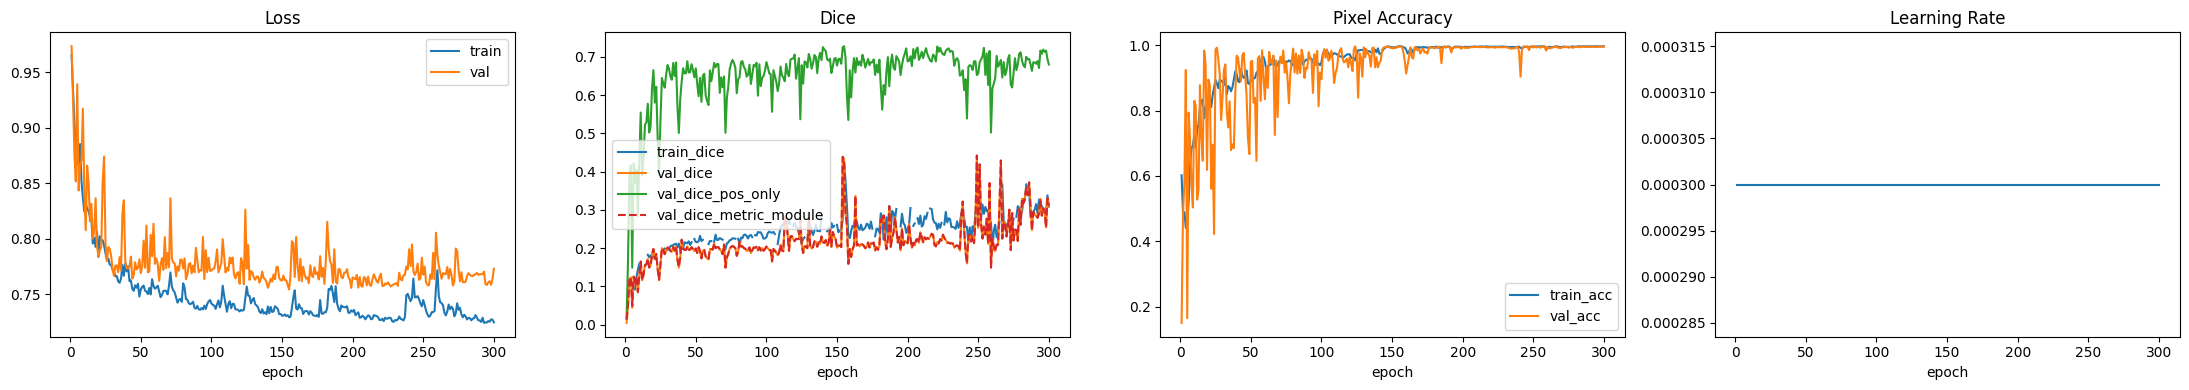

In [8]:
epochs = np.arange(1, len(history["train_loss"]) + 1)
fig, axes = plt.subplots(1, 4, figsize=(22, 4))

axes[0].plot(epochs, history["train_loss"], label="train")
axes[0].plot(epochs, history["val_loss"], label="val")
axes[0].set_title("Loss")
axes[0].set_xlabel("epoch")
axes[0].legend()

axes[1].plot(epochs, history["train_dice"], label="train_dice")
axes[1].plot(epochs, history["val_dice"], label="val_dice")
axes[1].plot(epochs, history["val_dice_pos_only"], label="val_dice_pos_only")
axes[1].plot(epochs, history["val_dice_metric_module"], label="val_dice_metric_module", linestyle="--")
axes[1].set_title("Dice")
axes[1].set_xlabel("epoch")
axes[1].legend()

axes[2].plot(epochs, history["train_accuracy"], label="train_acc")
axes[2].plot(epochs, history["val_accuracy"], label="val_acc")
axes[2].set_title("Pixel Accuracy")
axes[2].set_xlabel("epoch")
axes[2].legend()

axes[3].plot(epochs, history["lr"])
axes[3].set_title("Learning Rate")
axes[3].set_xlabel("epoch")

plt.tight_layout()
plt.show()


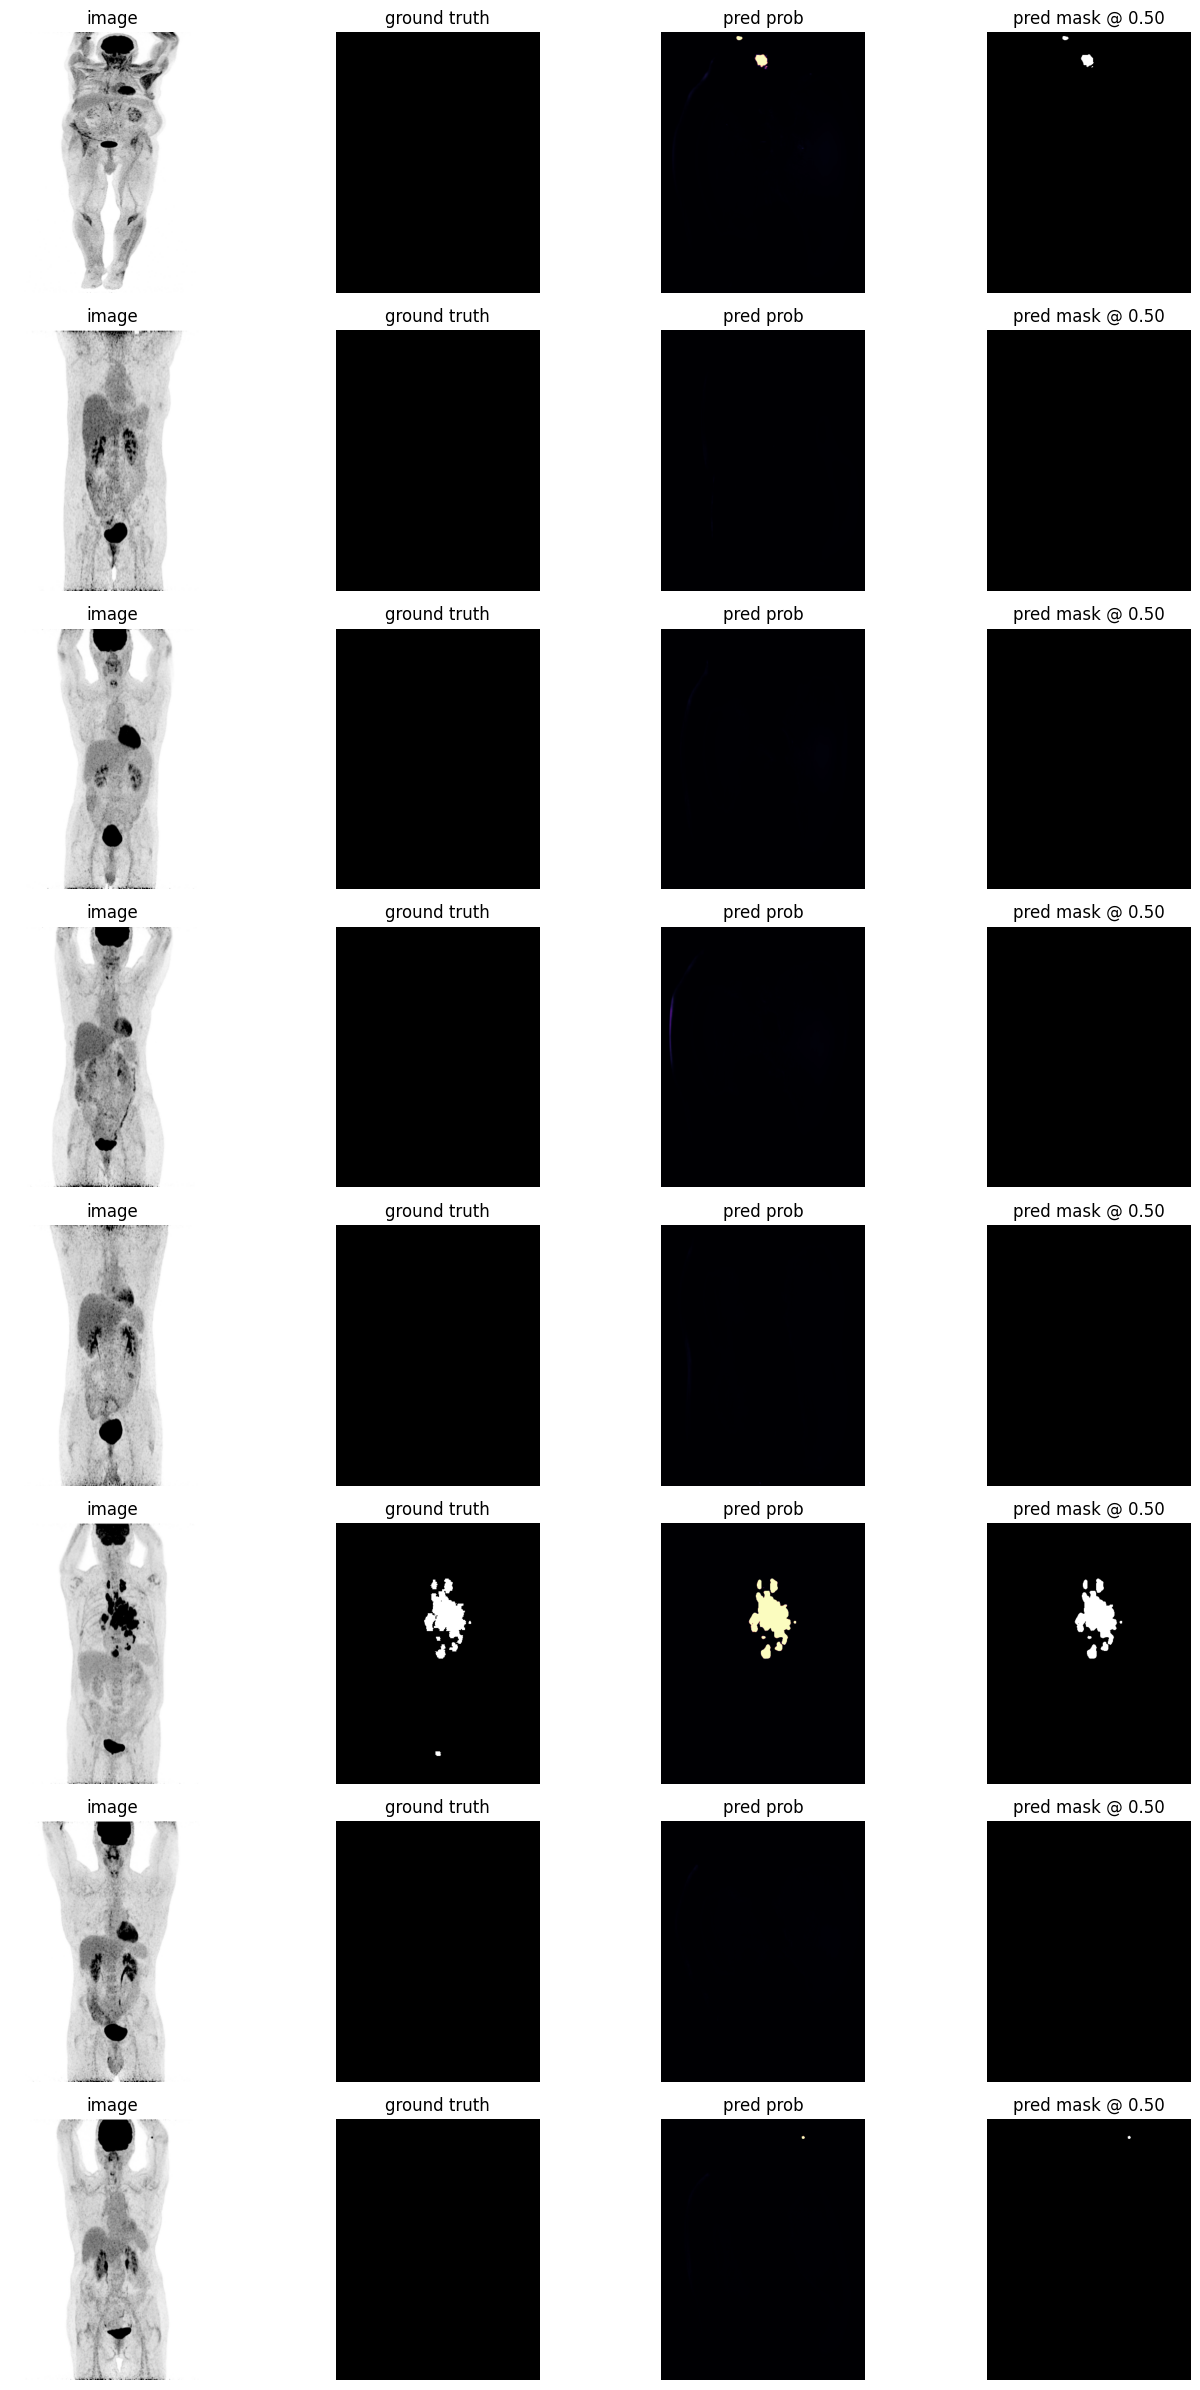

In [9]:
def visualize_predictions(dataset: Subset, num_samples: int = 8, threshold: float | None = None, seed: int = 0) -> None:
    model.eval()
    rng = np.random.default_rng(seed)
    threshold = cfg.threshold if threshold is None else threshold

    picks = rng.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    fig, axes = plt.subplots(len(picks), 4, figsize=(14, 3 * len(picks)))
    if len(picks) == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for row, local_idx in enumerate(picks):
            image, target = dataset[int(local_idx)]
            logits = model(image.unsqueeze(0).to(device))
            probs = torch.sigmoid(logits).squeeze().cpu()
            pred = (probs >= threshold).float()

            image_show = denormalize_image_tensor(image)
            target_np = target[0].cpu().numpy()
            probs_np = probs.numpy()
            pred_np = pred.numpy()

            if image_show.shape[0] == 1:
                axes[row, 0].imshow(image_show[0].numpy(), cmap="gray")
            else:
                axes[row, 0].imshow(image_show.permute(1, 2, 0).numpy())

            axes[row, 1].imshow(target_np, cmap="gray", vmin=0, vmax=1)
            axes[row, 2].imshow(probs_np, cmap="magma", vmin=0, vmax=1)
            axes[row, 3].imshow(pred_np, cmap="gray", vmin=0, vmax=1)

            axes[row, 0].set_title("image")
            axes[row, 1].set_title("ground truth")
            axes[row, 2].set_title("pred prob")
            axes[row, 3].set_title(f"pred mask @ {threshold:.2f}")

            for col in range(4):
                axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(val_dataset, num_samples=8)


best overall dice threshold = 0.95, score = 0.4501
best positive-only dice threshold = 0.95, score = 0.7350
threshold selection rule: max precision with recall >= 0.60
selected threshold = 0.95 | precision=0.4545, recall=0.8634, F0.50=0.5020
Updated cfg.threshold to 0.95 for downstream visualizations/evaluation.


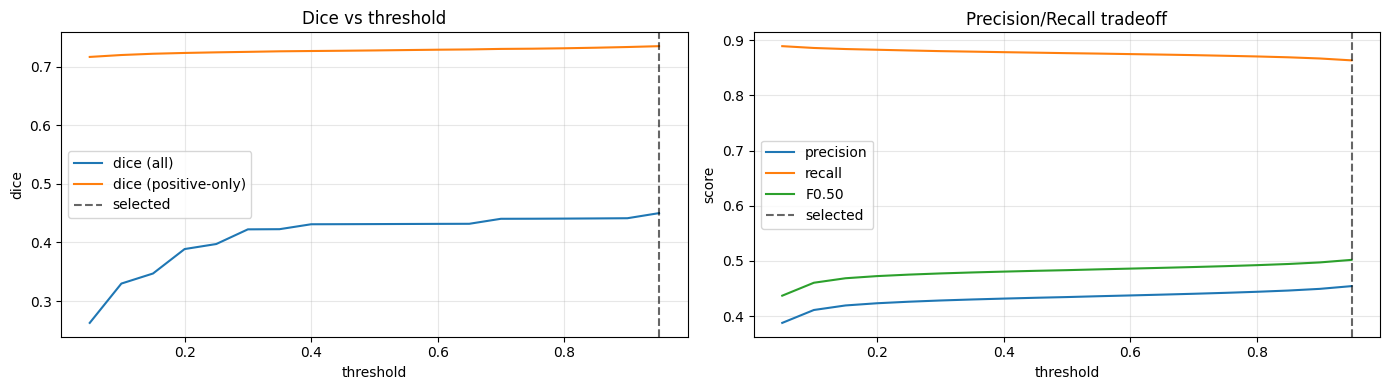

In [10]:
def _binary_confusion_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
    threshold: float,
) -> tuple[float, float, float]:
    logits, targets = _prepare_dice_tensors(logits, targets)
    probs = torch.sigmoid(logits)
    preds = probs >= threshold
    targets_bin = targets >= 0.5

    tp = float((preds & targets_bin).sum().item())
    fp = float((preds & (~targets_bin)).sum().item())
    fn = float(((~preds) & targets_bin).sum().item())
    return tp, fp, fn


def threshold_sweep(model: nn.Module, loader: DataLoader, thresholds: np.ndarray) -> dict[str, np.ndarray]:
    model.eval()
    all_scores = []
    pos_scores = []
    precision_scores = []
    recall_scores = []
    fbeta_scores = []

    beta2 = float(cfg.threshold_fbeta_beta) ** 2

    with torch.no_grad():
        for thr in thresholds:
            total = 0.0
            count = 0
            pos_total = 0.0
            pos_count = 0
            tp_total = 0.0
            fp_total = 0.0
            fn_total = 0.0

            for images, targets in loader:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                logits = model(images)

                per_sample = per_sample_dice_from_logits(logits, targets, threshold=float(thr))
                total += float(per_sample.sum().item())
                count += int(per_sample.numel())

                has_pos = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
                if has_pos.any():
                    pos_total += float(per_sample[has_pos].sum().item())
                    pos_count += int(has_pos.sum().item())

                tp, fp, fn = _binary_confusion_from_logits(logits, targets, threshold=float(thr))
                tp_total += tp
                fp_total += fp
                fn_total += fn

            precision = tp_total / max(tp_total + fp_total, 1.0)
            recall = tp_total / max(tp_total + fn_total, 1.0)
            fbeta = (1.0 + beta2) * precision * recall / max(beta2 * precision + recall, 1e-8)

            all_scores.append(total / max(count, 1))
            pos_scores.append(pos_total / max(pos_count, 1))
            precision_scores.append(precision)
            recall_scores.append(recall)
            fbeta_scores.append(fbeta)

    return {
        "dice_all": np.array(all_scores),
        "dice_pos_only": np.array(pos_scores),
        "precision": np.array(precision_scores),
        "recall": np.array(recall_scores),
        "fbeta": np.array(fbeta_scores),
    }


thresholds = np.linspace(0.05, 0.95, 19)
curves = threshold_sweep(model, val_loader, thresholds)

all_dice_curve = curves["dice_all"]
pos_dice_curve = curves["dice_pos_only"]
precision_curve = curves["precision"]
recall_curve = curves["recall"]
fbeta_curve = curves["fbeta"]

best_all_idx = int(np.argmax(all_dice_curve))
best_pos_idx = int(np.argmax(pos_dice_curve))

valid_recall = recall_curve >= cfg.threshold_min_recall
if valid_recall.any():
    precision_with_constraint = np.where(valid_recall, precision_curve, -1.0)
    best_idx = int(np.argmax(precision_with_constraint))
    selection_rule = f"max precision with recall >= {cfg.threshold_min_recall:.2f}"
else:
    best_idx = int(np.argmax(fbeta_curve))
    selection_rule = f"fallback max F{cfg.threshold_fbeta_beta:.2f}"

cfg.threshold = float(thresholds[best_idx])

print(f"best overall dice threshold = {thresholds[best_all_idx]:.2f}, score = {all_dice_curve[best_all_idx]:.4f}")
print(f"best positive-only dice threshold = {thresholds[best_pos_idx]:.2f}, score = {pos_dice_curve[best_pos_idx]:.4f}")
print(f"threshold selection rule: {selection_rule}")
print(
    f"selected threshold = {cfg.threshold:.2f} | "
    f"precision={precision_curve[best_idx]:.4f}, "
    f"recall={recall_curve[best_idx]:.4f}, "
    f"F{cfg.threshold_fbeta_beta:.2f}={fbeta_curve[best_idx]:.4f}"
)
print(f"Updated cfg.threshold to {cfg.threshold:.2f} for downstream visualizations/evaluation.")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(thresholds, all_dice_curve, label="dice (all)")
axes[0].plot(thresholds, pos_dice_curve, label="dice (positive-only)")
axes[0].axvline(cfg.threshold, color="black", linestyle="--", alpha=0.6, label="selected")
axes[0].set_xlabel("threshold")
axes[0].set_ylabel("dice")
axes[0].set_title("Dice vs threshold")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(thresholds, precision_curve, label="precision")
axes[1].plot(thresholds, recall_curve, label="recall")
axes[1].plot(thresholds, fbeta_curve, label=f"F{cfg.threshold_fbeta_beta:.2f}")
axes[1].axvline(cfg.threshold, color="black", linestyle="--", alpha=0.6, label="selected")
axes[1].set_xlabel("threshold")
axes[1].set_ylabel("score")
axes[1].set_title("Precision/Recall tradeoff")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


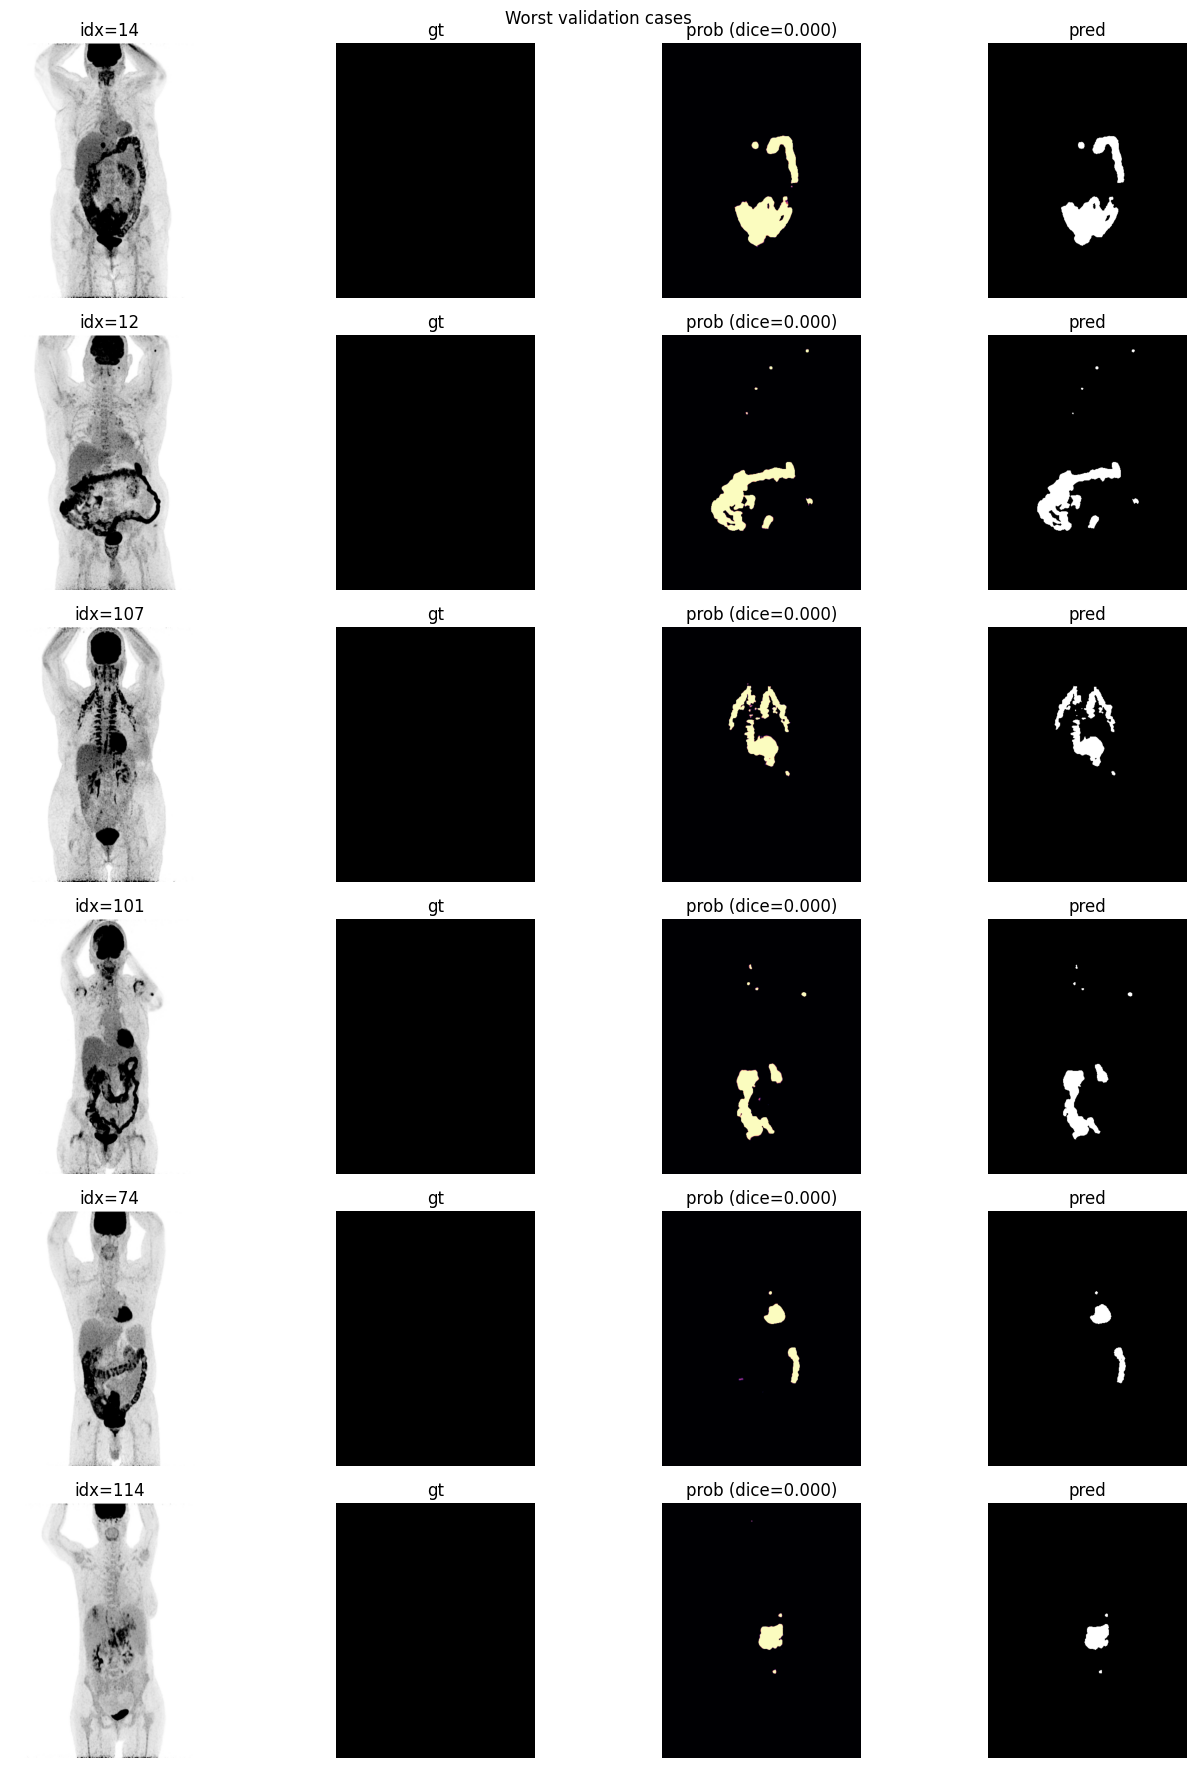

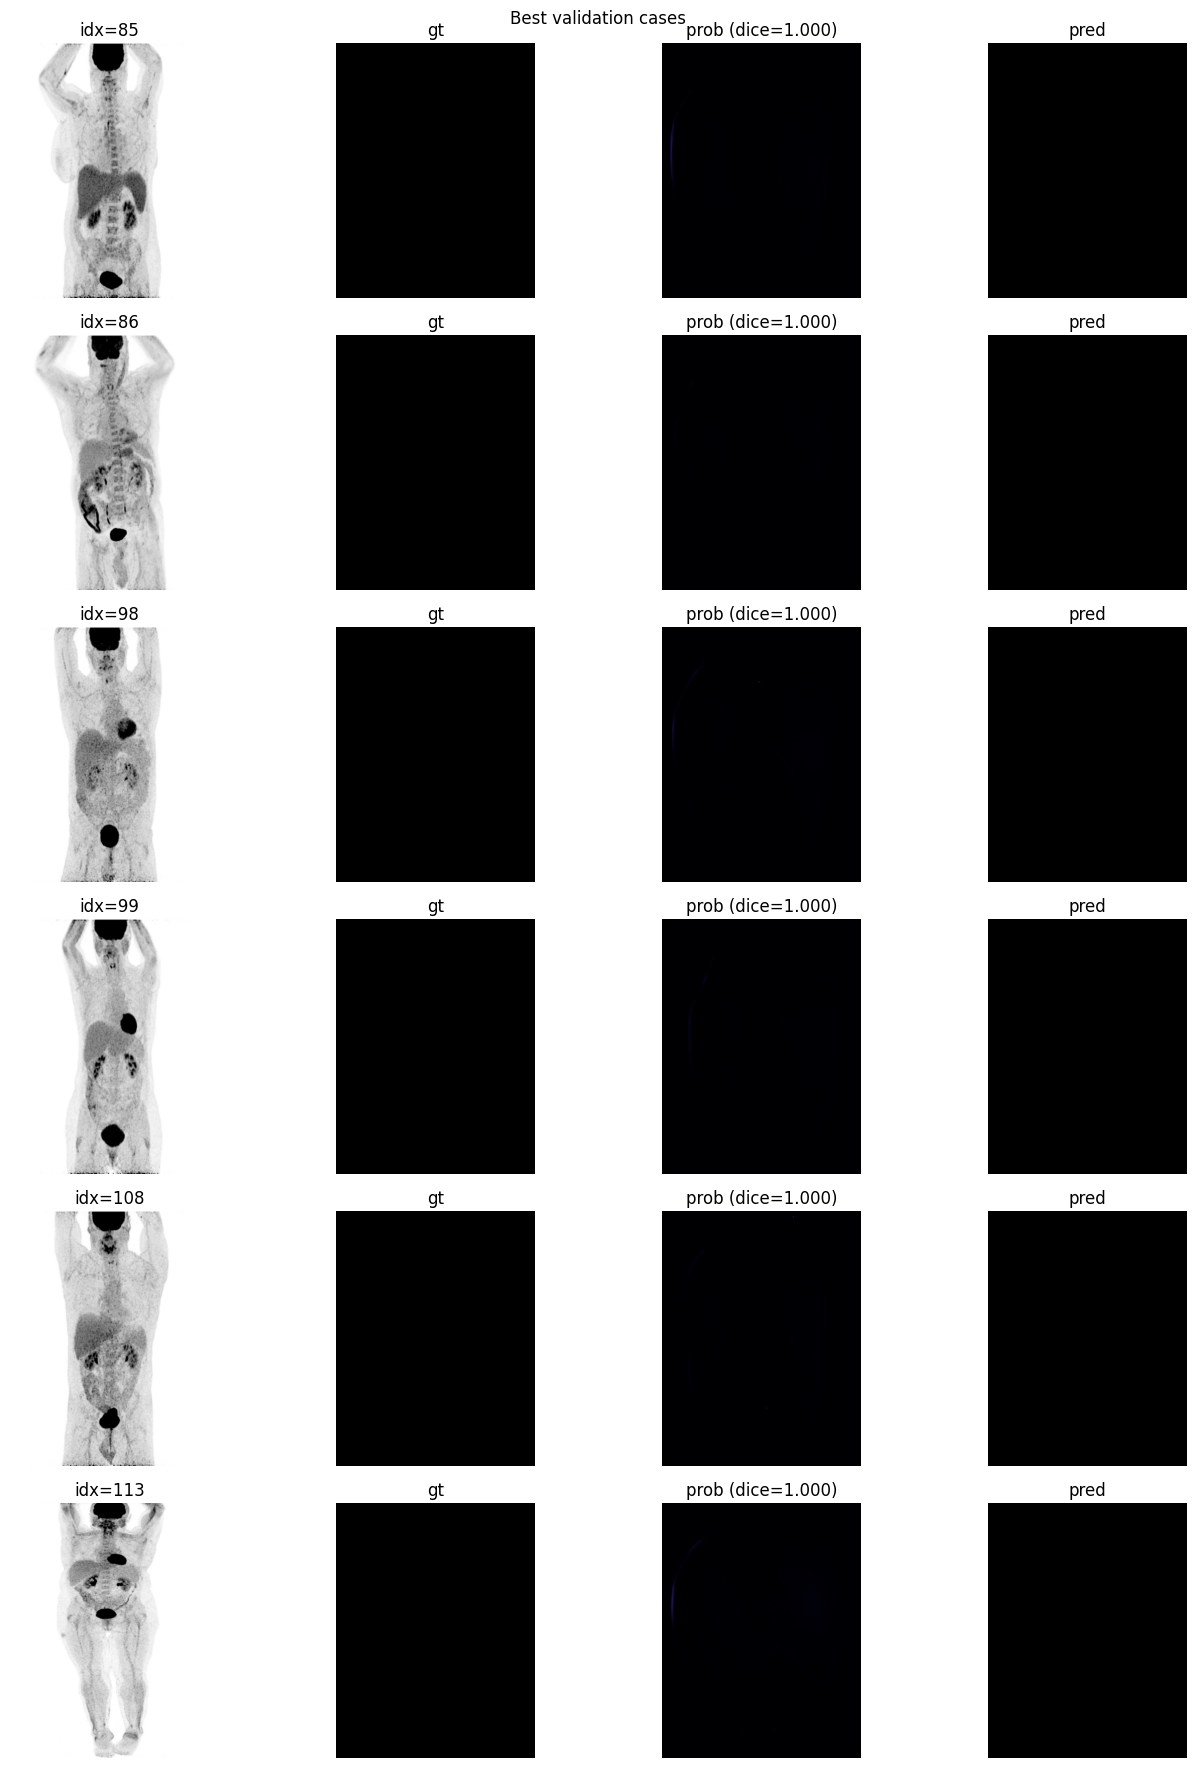

In [11]:
def collect_hard_cases(dataset: Subset, num_cases: int = 6, threshold: float | None = None):
    model.eval()
    threshold = cfg.threshold if threshold is None else threshold

    records = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, target = dataset[i]
            logits = model(image.unsqueeze(0).to(device))
            score = float(per_sample_dice_from_logits(logits, target.unsqueeze(0).to(device), threshold=threshold)[0].item())
            records.append((score, i, image.cpu(), target.cpu(), torch.sigmoid(logits).squeeze().cpu()))

    records.sort(key=lambda x: x[0])
    return records[:num_cases], records[-num_cases:]


def show_case_records(records, title: str, threshold: float | None = None):
    threshold = cfg.threshold if threshold is None else threshold
    fig, axes = plt.subplots(len(records), 4, figsize=(14, 3 * len(records)))
    if len(records) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, (score, idx, image, target, prob) in enumerate(records):
        image_show = denormalize_image_tensor(image)
        pred = (prob >= threshold).float()

        if image_show.shape[0] == 1:
            axes[r, 0].imshow(image_show[0].numpy(), cmap="gray")
        else:
            axes[r, 0].imshow(image_show.permute(1, 2, 0).numpy())

        axes[r, 1].imshow(target[0].numpy(), cmap="gray", vmin=0, vmax=1)
        axes[r, 2].imshow(prob.numpy(), cmap="magma", vmin=0, vmax=1)
        axes[r, 3].imshow(pred.numpy(), cmap="gray", vmin=0, vmax=1)

        axes[r, 0].set_title(f"idx={idx}")
        axes[r, 1].set_title("gt")
        axes[r, 2].set_title(f"prob (dice={score:.3f})")
        axes[r, 3].set_title("pred")

        for c in range(4):
            axes[r, c].axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


worst_cases, best_cases = collect_hard_cases(val_dataset, num_cases=6)
show_case_records(worst_cases, "Worst validation cases")
show_case_records(best_cases, "Best validation cases")


In [12]:
# Optional quick ablation to compare encoder pretraining choices for this PET setup.
# This runs short experiments and compares best val_dice_pos_only.

def run_short_experiment(encoder_weights: str | None, epochs: int = 8) -> float:
    local_model = smp.Unet(
        encoder_name=cfg.encoder_name,
        encoder_weights=encoder_weights,
        in_channels=cfg.image_channels,
        classes=cfg.classes,
        activation=cfg.activation,
    ).to(device)

    local_optimizer = torch.optim.AdamW(local_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    local_scaler = build_grad_scaler(enabled=use_amp)

    def local_run_epoch(loader: DataLoader, train: bool):
        local_model.train(mode=train)
        pos_best = 0.0
        total_pos = 0.0
        pos_count = 0
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            with torch.set_grad_enabled(train):
                with autocast_context():
                    logits = local_model(images)
                    loss = repo_dice_loss(logits, targets)

                if train:
                    local_optimizer.zero_grad(set_to_none=True)
                    if use_amp:
                        local_scaler.scale(loss).backward()
                        local_scaler.step(local_optimizer)
                        local_scaler.update()
                    else:
                        loss.backward()
                        local_optimizer.step()

            with torch.no_grad():
                d = per_sample_dice_from_logits(logits, targets, threshold=cfg.threshold)
                has_pos = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
                if has_pos.any():
                    total_pos += float(d[has_pos].sum().item())
                    pos_count += int(has_pos.sum().item())

        return total_pos / max(pos_count, 1)

    best = -1.0
    for _ in range(epochs):
        _ = local_run_epoch(train_loader, train=True)
        val_pos = local_run_epoch(val_loader, train=False)
        best = max(best, val_pos)

    return best


# Uncomment to run:
# for w in [None, "imagenet"]:
#     score = run_short_experiment(encoder_weights=w, epochs=8)
#     print(f"encoder_weights={w}: best val_dice_pos_only={score:.4f}")
